In [1]:
import random
import numpy as np
import pandas as pd
from scipy.sparse import dia_array
from scipy.sparse.linalg import spsolve


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
import pickle

In [2]:
folder = Path('./models/')
folder.is_dir()


True

## Samples Generator

In [3]:
def tensor2matrix(t):
    ni, nj = t[0].shape

    diag_ni_u = torch.flatten(t[0].transpose(0,1))
    diag_1_u = torch.flatten(t[1].transpose(0,1))
    diag_1_l = torch.flatten(t[2].transpose(0,1))
    diag_ni_l = torch.flatten(t[3].transpose(0,1))

    n_diag = ni*nj
    main_diag = np.ones(n_diag)
    data = np.array([diag_ni_l,diag_1_l, main_diag, diag_1_u,diag_ni_u])
    offsets = np.array([-ni,-1, 0, 1,ni])
    m = dia_array((data, offsets), shape=(n_diag, n_diag))

    return m

def make_tensor(number_generator,
                args={},
                symmetric=True,
                off_diagonal_abs_mean=0.5,
                grid_size=(5, 5)):

    #Generate values
    ni, nj = grid_size
    n_diag_1 = (ni-1)*nj
    n_diag_ni = ni*(nj-1)

    diag_1_u = [number_generator(**args) for _ in range(n_diag_1)]
    diag_ni_u = [number_generator(**args) for _ in range(n_diag_ni)]

    if symmetric:
        diag_1_l = diag_1_u
        diag_ni_l = diag_ni_u
    else:
        diag_1_l = [number_generator(**args) for _ in range(n_diag_1)]
        diag_ni_l = [number_generator(**args) for _ in range(n_diag_ni)]

    #To tensor
    diag_1_u = torch.tensor(diag_1_u).float()
    diag_1_l = torch.tensor(diag_1_l).float()
    diag_ni_u = torch.tensor(diag_ni_u).float()
    diag_ni_l = torch.tensor(diag_ni_l).float()

    #Scale off main diagonal
    off_diagonal = torch.cat([diag_ni_u, diag_1_u, diag_1_l, diag_ni_l])
    off_diagonal = torch.abs(off_diagonal)
    mean_abs = torch.mean(off_diagonal)
    alpha = off_diagonal_abs_mean / mean_abs
    diag_1_u = torch.mul(diag_1_u, alpha)
    diag_1_l = torch.mul(diag_1_l, alpha)
    diag_ni_u = torch.mul(diag_ni_u, alpha)
    diag_ni_l = torch.mul(diag_ni_l, alpha)

    #Adjust zeroes
    diag_1_u = torch.reshape(diag_1_u, (ni-1,nj))
    diag_1_u = torch.cat([torch.zeros(1,nj), diag_1_u], dim=0)

    diag_1_l = torch.reshape(diag_1_l, (ni-1,nj))
    diag_1_l = torch.cat([diag_1_l, torch.zeros(1,nj)], dim=0)

    diag_ni_l = torch.reshape(diag_ni_l, (ni,nj-1))
    diag_ni_l = torch.cat([diag_ni_l, torch.zeros(ni,1)], dim=1)

    diag_ni_u = torch.reshape(diag_ni_u, (ni,nj-1))
    diag_ni_u = torch.cat([torch.zeros(ni,1), diag_ni_u], dim=1)

    t = torch.cat([diag_ni_u.unsqueeze(0),
                    diag_1_u.unsqueeze(0),
                    diag_1_l.unsqueeze(0),
                    diag_ni_l.unsqueeze(0)],
                    dim=0)
    return t

In [4]:
def get_sample(number_generator,
               args={},
               symmetric=True,
               off_diagonal_abs_mean=0.5,
               grid_size=(5, 5)):

    A = make_tensor(number_generator=number_generator,
                    args=args,
                    symmetric=symmetric,
                    off_diagonal_abs_mean=off_diagonal_abs_mean,
                    grid_size=grid_size)

    ni, nj = grid_size
    n_diag = ni*nj
    x_true = [number_generator(**args) for _ in range(n_diag)]

    A_mat = tensor2matrix(A)
    b = A_mat.dot(x_true)
    b = torch.tensor(b, dtype=torch.float32)
    b = torch.reshape(b, (nj,ni)).transpose(0,1)

    X = torch.cat([A, b.unsqueeze(0)], dim=0)
    x_true = torch.tensor(x_true).float()
    y = torch.reshape(x_true, (nj,ni)).transpose(0,1)
    return (X, y)

In [5]:
def check_sample(X, y, result='max', print_cond_number=False, verbose=False):

    def _error_from_y(X,y):
        custom_weights = np.array([
            [[0, 0, 0],
             [0, 1, 0],
             [0, 0, 0]],
            [[0, 0, 0],
             [0, 0, 1],
             [0, 0, 0]],
            [[0, 0, 0],
             [0, 0, 0],
             [0, 1, 0]],
            [[0, 1, 0],
             [0, 0, 0],
             [0, 0, 0]],
            [[0, 0, 0],
             [1, 0, 0],
             [0, 0, 0]],
            ], dtype=np.float32)
        custom_weights_tensor = torch.tensor(custom_weights).unsqueeze(0)  # Add batch dimensions
        conv_layer = nn.Conv2d(in_channels=5, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        conv_layer.weight = nn.Parameter(custom_weights_tensor, requires_grad=False)

        ni, nj = X[0].shape
        X_ = torch.cat([torch.ones((ni,nj)).unsqueeze(0), X[:4]])
        residuals = conv_layer(X_ * y) - X[-1]
        residuals = torch.flatten(residuals.transpose(0,1))
        return residuals

    def _error_from_solve(X):
        A = tensor2matrix(X[:4])
        b = torch.flatten(X[-1].transpose(0,1)).tolist()
        y_aprox = spsolve(A.tocsr(), b)
        residuals = A.dot(y_aprox) - b
        y_aprox = torch.tensor(y_aprox)
        residuals = torch.tensor(residuals)
        return residuals, y_aprox

    def _get_result(output_tensor, reference_tensor):
        if result == 'sum_abs':
            return float(torch.sum(torch.abs(output_tensor)))
        if result == 'max':
            return float(torch.max(torch.abs(output_tensor)))
        if result == 'sum2':
            return float(torch.sum(torch.square(output_tensor)))
        if result == 'max_rel':
            return float(torch.max(torch.abs(output_tensor) / torch.abs(reference_tensor)))
        raise ValueError(f'Invalid option: {result}.')


    y_ = torch.flatten(y.transpose(0,1))
    if print_cond_number and verbose:
        A = tensor2matrix(X[:4])
        cond_num = np.linalg.cond(A.toarray())
        print(f'Matrix condition number: {cond_num:0.4g}')

    residuals_from_y = _error_from_y(X,y)
    error_from_y = _get_result(residuals_from_y, y_)

    residuals_from_solve, y_aprox = _error_from_solve(X)
    error_from_solve = _get_result(residuals_from_solve, y_)
    error_delta_y = _get_result(y_ - y_aprox, y_)

    if verbose:
        print(f'Result using provided y: {error_from_y:0.4g}')
        print(f'Result using sparse solver: {error_from_solve:0.4g}')
        print(f'Difference in y vectors: {error_delta_y:0.4g}')

    return residuals_from_y, residuals_from_solve, y_aprox, y_

In [6]:
ni, nj = 100, 100
number_generator = random.uniform
args = {'a':1,'b':5}

X, y = get_sample(
    number_generator=number_generator,
    args=args,
    grid_size=(ni,nj),
    off_diagonal_abs_mean=0.5,
    symmetric=False)
print(f'X: {X.shape}')
print(f'Dense matrix: {tensor2matrix(X[:4]).shape}')
print(f'y: {y.shape}')

check_sample(X,y, 'max_rel', print_cond_number=False, verbose=True) #max, sum_abs, sum2, max_rel

X: torch.Size([5, 100, 100])
Dense matrix: (10000, 10000)
y: torch.Size([100, 100])
Result using provided y: 1.831e-06
Result using sparse solver: 4.101e-14
Difference in y vectors: 0.0001066


(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([ 0.0000e+00,  4.4409e-16,  0.0000e+00,  ...,  0.0000e+00,
         -8.8818e-16,  0.0000e+00], dtype=torch.float64),
 tensor([2.3170, 1.0401, 3.1009,  ..., 1.0573, 1.4961, 1.7728],
        dtype=torch.float64),
 tensor([2.3171, 1.0401, 3.1009,  ..., 1.0572, 1.4961, 1.7728]))

## Dataloader

In [7]:
number_generator = random.uniform
args_gen = {'a':-5,'b':5}
off_diagonal_abs_mean=0.5

class CustomDataset(Dataset):
    def __init__(self, ni, nj, n):
        self.ni = ni
        self.nj = nj
        self.n  = n

    def __len__(self):
        return self.n

    def __getitem__(self, idx):

        X, y = get_sample(
            number_generator=number_generator,
            args=args_gen,
            grid_size=(self.ni,self.nj),
            off_diagonal_abs_mean=off_diagonal_abs_mean,
            symmetric=False)

        return (X, y.unsqueeze(0))

In [8]:
ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
batch_size = 64
dataloader_ = DataLoader(data_train, batch_size=batch_size, shuffle=False)

for X,y in dataloader_:
    print(f'Input shape: {X.shape}')
    print(f'Output shape: {y.shape}')
    break

Input shape: torch.Size([64, 5, 10, 10])
Output shape: torch.Size([64, 1, 10, 10])


## Neural Network Definition

Adicionar opções de:

* Layer-wise Conv2D.
* Autoencoder para tentar reduzir número de canais na entrada.
* Inception com número maior de caminhos.
* Adicionar valores log do absoluto das entradas.
* Kernel simétrico nas camadas convolucionais.
* Ajuste gradual com matrizes maiores.
* Entrar com uma maior variedade de geradores de números aleatórios.
* Variar tamanho das malhas durante o treinamento.

In [9]:
#https://pt.d2l.ai/chapter_convolutional-modern/googlenet.html

def _divide_inception(latent_size, n_paths=4):
    r = latent_size % n_paths
    d = int((latent_size-r)/n_paths)
    c = [d]*n_paths
    for i in range(n_paths-1):
        c[i] = d+(r>i)
    return c

class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2, kernel_size=1)
        self.p2_2 = nn.Conv2d(c2, c2, kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3, kernel_size=1)
        self.p3_2 = nn.Conv2d(c3, c3, kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [10]:
class Network(nn.Module):

    def __init__(self, n_blocks, latent_size,
                 input_dim=5,
                 activation=True,
                 batch_norm=True,
                 use_residual=False,
                 deep_residual=False,
                 use_inception=False,
                 include_log=False):
        super(Network,self).__init__()

        if include_log:
            input_dim *= 2

        if activation:
            self.input = nn.Sequential(
                nn.Conv2d(input_dim, latent_size, 1, padding=0),
                nn.ReLU()
            )
        else:
            self.input = nn.Conv2d(input_dim, latent_size, 1, padding=0)

        self.process = nn.ModuleList()
        if use_inception:
            c = _divide_inception(latent_size)
            if batch_norm:
                for _ in range(n_blocks):
                    self.process.append(
                        nn.Sequential(
                            Inception(latent_size, c[0], c[1], c[2], c[3]),
                            nn.BatchNorm2d(latent_size)
                        ))
            else:
                for _ in range(n_blocks):
                    self.process.append(Inception(latent_size, c[0], c[1], c[2], c[3]))
        elif activation and batch_norm:
            for _ in range(n_blocks):
                self.process.append(
                    nn.Sequential(
                        nn.Conv2d(latent_size, latent_size, 3, padding=1),
                        nn.BatchNorm2d(latent_size),
                        nn.ReLU()
                    )
                )
        elif batch_norm:
            for _ in range(n_blocks):
                self.process.append(
                    nn.Sequential(
                        nn.Conv2d(latent_size, latent_size, 3, padding=1),
                        nn.BatchNorm2d(latent_size)
                    )
                )
        elif activation:
            for _ in range(n_blocks):
                self.process.append(
                    nn.Sequential(
                        nn.Conv2d(latent_size, latent_size, 3, padding=1),
                        nn.ReLU()
                    )
                )
        else:
            for _ in range(n_blocks):
                self.process.append(nn.Conv2d(latent_size, latent_size, 3, padding=1))

        self.output = nn.Conv2d(latent_size, 1, 1, padding=0)

        self.include_log = include_log
        self.use_residual = use_residual
        self.deep_residual = deep_residual

    def forward(self, x):

        if self.use_residual:
            if len(x.shape) > 3:
                b = x[:,-1].unsqueeze(1)
            else:
                b = x[-1].unsqueeze(0)

        if self.include_log:
            x = torch.cat((x, torch.log(torch.abs(x))), dim=1)

        x = self.input(x)

        for layer in self.process:
            if self.deep_residual:
                residual = x[:]

            x = layer(x)

            if self.deep_residual:
                x += residual

        x = self.output(x)

        if self.use_residual:
            x += b

        return x

In [11]:
model = Network(
    n_blocks=2,
    latent_size=8,
    activation=True,
    batch_norm=True,
    use_residual=True,
    deep_residual=False,
    use_inception=True)

X, y = get_sample(
            number_generator=number_generator,
            args=args,
            grid_size=(ni,nj),
            off_diagonal_abs_mean=off_diagonal_abs_mean,
            symmetric=False)

print(f'Input: {X.unsqueeze(0).shape}')
loss_fn = nn.MSELoss()
result = model(X.unsqueeze(0))
print(f'Result: {result.shape}')
print(f'Output: {y.unsqueeze(0).shape}')

# torch.autograd.set_detect_anomaly(True)
loss = loss_fn(result, y.unsqueeze(0).unsqueeze(0))
loss.backward()
print(f'Loss = {loss:0.2f}')

Input: torch.Size([1, 5, 10, 10])
Result: torch.Size([1, 1, 10, 10])
Output: torch.Size([1, 10, 10])
Loss = 30.02


In [12]:
loss_fn = nn.MSELoss()

for X,y in dataloader_:
    print(f'Input: {X.shape}')
    result = model(X)
    print(f'Result: {result.shape}')

    loss = loss_fn(result, y)
    loss.backward()
    print(f'Loss = {loss:0.2f}')
    break

Input: torch.Size([64, 5, 10, 10])
Result: torch.Size([64, 1, 10, 10])
Loss = 10.43


In [13]:
print(model)

Network(
  (input): Sequential(
    (0): Conv2d(5, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (process): ModuleList(
    (0-1): 2 x Sequential(
      (0): Inception(
        (p1_1): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
        (p2_1): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
        (p2_2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (p3_1): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
        (p3_2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (p4_2): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (output): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [14]:
def get_number_parameters(model, verbose=False):
    total = 0
    layers = 0
    for name, param in model.named_parameters():
        if verbose:
            print(f"Layer: {name} | Parameters: {param.numel()}")
        total += param.numel()
        layers += 1
    if verbose:
        print(f'Total: {total}')
    return total, int(layers/2)

get_number_parameters(model, True)

Layer: input.0.weight | Parameters: 40
Layer: input.0.bias | Parameters: 8
Layer: process.0.0.p1_1.weight | Parameters: 16
Layer: process.0.0.p1_1.bias | Parameters: 2
Layer: process.0.0.p2_1.weight | Parameters: 16
Layer: process.0.0.p2_1.bias | Parameters: 2
Layer: process.0.0.p2_2.weight | Parameters: 36
Layer: process.0.0.p2_2.bias | Parameters: 2
Layer: process.0.0.p3_1.weight | Parameters: 16
Layer: process.0.0.p3_1.bias | Parameters: 2
Layer: process.0.0.p3_2.weight | Parameters: 100
Layer: process.0.0.p3_2.bias | Parameters: 2
Layer: process.0.0.p4_2.weight | Parameters: 16
Layer: process.0.0.p4_2.bias | Parameters: 2
Layer: process.0.1.weight | Parameters: 8
Layer: process.0.1.bias | Parameters: 8
Layer: process.1.0.p1_1.weight | Parameters: 16
Layer: process.1.0.p1_1.bias | Parameters: 2
Layer: process.1.0.p2_1.weight | Parameters: 16
Layer: process.1.0.p2_1.bias | Parameters: 2
Layer: process.1.0.p2_2.weight | Parameters: 36
Layer: process.1.0.p2_2.bias | Parameters: 2
Layer

(513, 16)

In [15]:
torch.onnx.export(model, X, folder / 'test.onnx', input_names=["features"], output_names=["results"])
# https://machinelearningmastery.com/visualizing-a-pytorch-model/
# https://netron.app/

## Train NN

In [16]:
device = 'cpu'

In [17]:
def plot_losses(train_losses, val_losses):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

    axes[0].plot(range(1,len(train_losses)+1), train_losses, label='Train')
    axes[0].plot(range(1,len(train_losses)+1), val_losses, label='Val')
    axes[0].set_xlabel("Epoch")
    axes[0].set_xlabel("RMSE")
    axes[0].set_title("Model Training")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(range(1,len(train_losses)+1), train_losses, label='Train')
    axes[1].plot(range(1,len(train_losses)+1), val_losses, label='Val')
    axes[1].set_yscale("log")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("RMSE")
    axes[1].set_title("Model Training")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        losses.append(loss)

        loss.backward()
        optimizer.step()

        if verbose:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * batch_size + len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return float(torch.tensor(losses).mean())

def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

# https://tutorials.pytorch.kr/intermediate/torch_compile_tutorial.html
# train_opt = torch.compile(train_loop, mode="reduce-overhead")
# test_opt = torch.compile(test_loop, mode="reduce-overhead")

def train(model: Network,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          epochs: int,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          scheduler=None,
          file_name='model.pth',
          verbose=False,
          patience=35):

    model.to(device)
    model.train()
    model_file_name = (folder / file_name).with_suffix('.pht')

    best_val = np.inf
    train_loss = []
    val_loss = []
    counter = 0
    print("=> Starting training")
    for t in range(epochs):
        if verbose:
            print(f"Epoch {t+1}\n-------------------------------")
        train_loss.append(train_loop(train_dataloader, model, loss_fn, optimizer, verbose))
        val_loss.append(test_loop(val_dataloader, model, loss_fn))
        star = ''
        if val_loss[-1]*1.01 < best_val:
            best_val = val_loss[-1]
            torch.save(model, model_file_name)
            star = '*'
            counter = 0
        if scheduler is not None:
            scheduler.step(val_loss[-1])
        print(f' {t + 1}: train = {train_loss[-1]:0.4g}, val = {val_loss[-1]:0.4g}{star}, lr = {scheduler.get_last_lr()[0]}')
        counter += 1
        if counter > patience:
            print(f"Early stopping. No improvement after {counter} epochs.")
            break
    print("Done!")
    best_model = torch.load(model_file_name)

    results_file_name = (folder / file_name).with_suffix('.pkl')
    with open(results_file_name, 'wb') as file:
        pickle.dump((train_loss, val_loss), file)

    return best_model, (train_loss, val_loss)

In [19]:
def new_test(args):
    results_file_name = (folder / args['file_name']).with_suffix('.args')
    with open(results_file_name, 'wb') as file:
        pickle.dump(args, file)

    model = Network(
        n_blocks=args['n_blocks'],
        latent_size=args['latent_size'],
        activation=args['activation'],
        batch_norm=args['batch_norm'],
        use_residual=args['use_residual'],
        deep_residual=args['deep_residual'],
        use_inception=args['use_inception'])
    loss_fn = nn.MSELoss()

    ni, nj = args['ni'], args['nj']
    data_train = CustomDataset(ni, nj, 10000)
    data_val = CustomDataset(ni, nj, 2000)
    data_test = CustomDataset(ni, nj, 2000)
    batch_size = args['batch_size']
    dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
    dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
    dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

    epochs = args['epochs']
    optimizer = args['optimizer'](model.parameters(), lr = args['lr'], **args['optimizer_args'])
    scheduler = args['scheduler'](optimizer, **args['scheduler_args'])
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_model, (train_loss, val_loss) = train( #model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)
          model=model,
          train_dataloader = dataloader_train,
          val_dataloader = dataloader_val,
          epochs=epochs,
          optimizer = optimizer,
          loss_fn = loss_fn,
          scheduler = scheduler,
          file_name = args['file_name'],
          verbose = False,
          patience = args['patience'])


    test_loss = test_loop(dataloader_test, model, loss_fn)
    print(f'Test loss = {test_loss:0.4g} (last model)')
    test_loss = test_loop(dataloader_test, best_model, loss_fn)
    print(f'Test loss = {test_loss:0.4g} (best model)')

    plot_losses(train_loss, val_loss)

    return best_model

In [20]:
args_vanilla = {
    'file_name': 'model',
    'n_blocks': 5,
    'latent_size': 8,
    'activation': True,
    'batch_norm':False,
    'use_residual': False,
    'deep_residual':False,
    'use_inception':False,
    'ni': 10,
    'nj': 10,
    'batch_size': 64,
    'epochs': 200,
    'optimizer': torch.optim.RMSprop,
    'optimizer_args': {},
    'lr': 0.01,
    'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'scheduler_args': {'mode':'min', 'factor':0.5, 'patience':10},
    'patience': 35,
}

In [21]:
def load_test(file_name):

    args_file_name = (folder / file_name).with_suffix('.args')
    with open(args_file_name, 'rb') as f:
        args = pickle.load(f)

    results_file_name = (folder / file_name).with_suffix('.pkl')
    with open(results_file_name, 'rb') as f:
        (train_loss, val_loss) = pickle.load(f)

    model_file_name = (folder / file_name).with_suffix('.pht')
    model = torch.load(model_file_name)

    return args, train_loss, val_loss, model

In [56]:
def test_sample(model, ni=10, nj=10, min_val=1, max_val=5):
    X, y = get_sample(
            number_generator=number_generator,
            args={'a':min_val, 'b':max_val},
            grid_size=(ni,nj),
            off_diagonal_abs_mean=off_diagonal_abs_mean,
            symmetric=False)
    model.eval()
    with torch.no_grad():
        y_hat = model(X.unsqueeze(0))[0][0]

    plt.figure(figsize=(10, 4))
    plt.plot(torch.flatten(y), label='Exact')
    plt.plot(torch.flatten(y_hat), label='Model')
    plt.xlabel("element")
    plt.ylabel("value")
    plt.title("Model Prediction")
    plt.legend()
    plt.grid(True)
    plt.show()

## Tests

In [40]:
def new_dict(base_dict, new_params):
    d = base_dict.copy()
    for k,v in new_params.items():
        if k not in base_dict:
            raise ValueError(f'{k} not found in base dictionary.')
        d[k] = v
    return d

### Tests 0

In [144]:
vanilla = new_dict(args_vanilla, {'file_name':'vanilla'})
model = new_test(vanilla)
test_sample(model)

=> Starting training
 1: train = 8.478, val = 8.351*, lr = 0.01
 2: train = 8.33, val = 8.332, lr = 0.01
 3: train = 8.326, val = 8.318, lr = 0.01
 4: train = 6.175, val = 4.449*, lr = 0.01
 5: train = 4.162, val = 4.071*, lr = 0.01
 6: train = 3.9, val = 3.84*, lr = 0.01
 7: train = 3.825, val = 3.924, lr = 0.01
 8: train = 3.788, val = 3.648*, lr = 0.01
 9: train = 3.715, val = 3.65, lr = 0.01
 10: train = 3.68, val = 3.588*, lr = 0.01
 11: train = 3.687, val = 4.364, lr = 0.01
 12: train = 3.649, val = 4.072, lr = 0.01
 13: train = 3.643, val = 3.636, lr = 0.01
 14: train = 3.593, val = 3.633, lr = 0.01
 15: train = 3.581, val = 3.478*, lr = 0.01
 16: train = 3.541, val = 3.445, lr = 0.01
 17: train = 3.375, val = 3.255*, lr = 0.01
 18: train = 3.334, val = 3.559, lr = 0.01
 19: train = 3.301, val = 3.132*, lr = 0.01
 20: train = 3.271, val = 3.512, lr = 0.01
 21: train = 3.252, val = 3.204, lr = 0.01
 22: train = 3.244, val = 3.233, lr = 0.01
 23: train = 3.221, val = 3.386, lr = 0

KeyboardInterrupt: 

### Tests 01

=> Starting training
 1: train = 7.043, val = 5.171*, lr = 0.01
 2: train = 4.804, val = 4.312*, lr = 0.01
 3: train = 4.096, val = 3.95*, lr = 0.01
 4: train = 3.967, val = 3.725*, lr = 0.01
 5: train = 3.861, val = 4.14, lr = 0.01
 6: train = 3.824, val = 3.701, lr = 0.01
 7: train = 3.731, val = 3.676*, lr = 0.01
 8: train = 3.719, val = 3.774, lr = 0.01
 9: train = 3.694, val = 3.684, lr = 0.01
 10: train = 3.694, val = 3.606*, lr = 0.01
 11: train = 3.666, val = 3.619, lr = 0.01
 12: train = 3.64, val = 3.635, lr = 0.01
 13: train = 3.624, val = 3.622, lr = 0.01
 14: train = 3.618, val = 3.743, lr = 0.01
 15: train = 3.598, val = 3.759, lr = 0.01
 16: train = 3.573, val = 3.435*, lr = 0.01
 17: train = 3.553, val = 3.481, lr = 0.01
 18: train = 3.478, val = 3.568, lr = 0.01
 19: train = 3.475, val = 3.503, lr = 0.01
 20: train = 3.452, val = 3.595, lr = 0.01
 21: train = 3.419, val = 3.474, lr = 0.01
 22: train = 3.418, val = 3.546, lr = 0.01
 23: train = 3.396, val = 3.597, lr = 

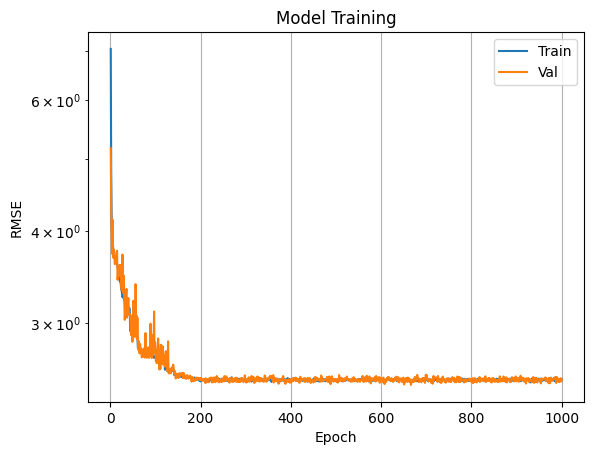

Test loss = 2.506 (last model)
Test loss = 2.529 (best model)


In [16]:
model = Network(
    n_blocks=5,
    latent_size=8,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 1000
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 21.42, val = 8.398*, lr = 0.01
 2: train = 8.328, val = 8.312*, lr = 0.01
 3: train = 8.328, val = 8.337, lr = 0.01
 4: train = 8.189, val = 7.728*, lr = 0.01
 5: train = 6.36, val = 5.801*, lr = 0.01
 6: train = 5.297, val = 5.17*, lr = 0.01
 7: train = 4.869, val = 4.755*, lr = 0.01
 8: train = 4.552, val = 4.852, lr = 0.01
 9: train = 4.366, val = 4.686*, lr = 0.01
 10: train = 4.273, val = 4.362*, lr = 0.01
 11: train = 4.208, val = 3.997*, lr = 0.01
 12: train = 4.083, val = 5.272, lr = 0.01
 13: train = 4.051, val = 4.222, lr = 0.01
 14: train = 3.888, val = 3.605*, lr = 0.01
 15: train = 3.63, val = 3.469*, lr = 0.01
 16: train = 3.478, val = 3.537, lr = 0.01
 17: train = 3.393, val = 3.21*, lr = 0.01
 18: train = 3.37, val = 3.257, lr = 0.01
 19: train = 3.348, val = 3.476, lr = 0.01
 20: train = 3.298, val = 3.467, lr = 0.01
 21: train = 3.309, val = 3.306, lr = 0.01
 22: train = 3.274, val = 3.492, lr = 0.01
 23: train = 3.262, val = 3.172*, l

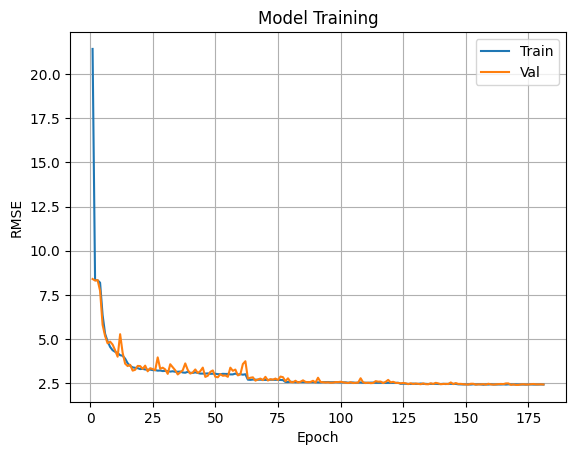

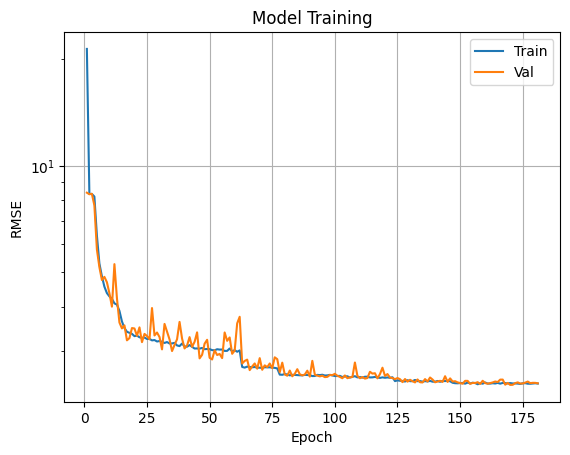

Test loss = 2.412 (last model)
Test loss = 2.405 (best model)


In [23]:
model = Network(
    n_blocks=10,
    latent_size=8,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 8.328, val = 8.337*, lr = 0.01
 2: train = 8.328, val = 8.354, lr = 0.01
 3: train = 8.331, val = 8.333, lr = 0.01
 4: train = 8.337, val = 8.355, lr = 0.01
 5: train = 8.325, val = 8.341, lr = 0.01
 6: train = 8.331, val = 8.304, lr = 0.01
 7: train = 8.328, val = 8.31, lr = 0.01
 8: train = 8.342, val = 8.32, lr = 0.01
 9: train = 8.336, val = 8.354, lr = 0.01
 10: train = 8.339, val = 8.319, lr = 0.01
 11: train = 8.333, val = 8.336, lr = 0.01
 12: train = 8.33, val = 8.304, lr = 0.01
 13: train = 8.337, val = 8.369, lr = 0.01
 14: train = 8.335, val = 8.323, lr = 0.01
 15: train = 8.337, val = 8.354, lr = 0.01
 16: train = 8.341, val = 8.332, lr = 0.01
 17: train = 8.337, val = 8.356, lr = 0.005
 18: train = 8.327, val = 8.352, lr = 0.005
 19: train = 8.326, val = 8.356, lr = 0.005
 20: train = 8.329, val = 8.328, lr = 0.005
 21: train = 8.342, val = 8.34, lr = 0.005
 22: train = 8.339, val = 8.366, lr = 0.005
 23: train = 8.336, val = 8.339, lr = 0

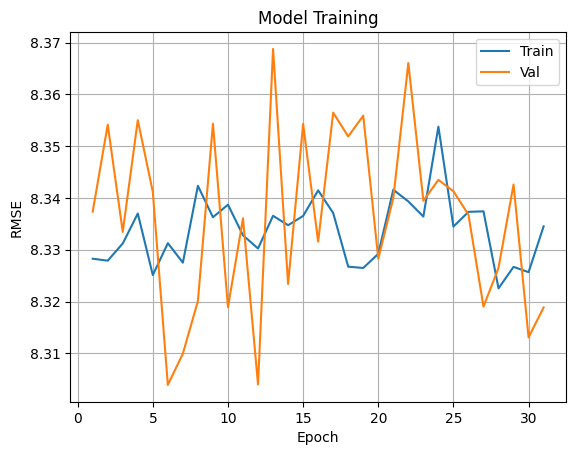

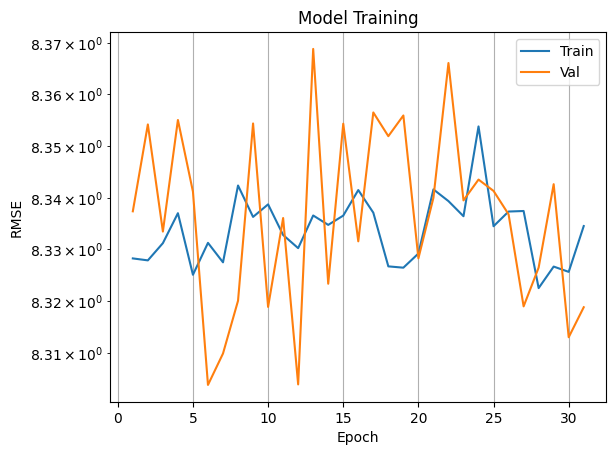

Test loss = 8.32 (last model)
Test loss = 8.337 (best model)


In [24]:
model = Network(
    n_blocks=5,
    latent_size=4,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 16.61, val = 8.303*, lr = 0.01
 2: train = 8.325, val = 8.356, lr = 0.01
 3: train = 8.341, val = 8.228, lr = 0.01
 4: train = 5.706, val = 4.13*, lr = 0.01
 5: train = 3.773, val = 3.619*, lr = 0.01
 6: train = 3.618, val = 3.47*, lr = 0.01
 7: train = 3.514, val = 3.41*, lr = 0.01
 8: train = 3.372, val = 3.312*, lr = 0.01
 9: train = 3.302, val = 3.694, lr = 0.01
 10: train = 3.198, val = 3.295, lr = 0.01
 11: train = 3.106, val = 3.198*, lr = 0.01
 12: train = 3.052, val = 2.777*, lr = 0.01
 13: train = 2.961, val = 3.043, lr = 0.01
 14: train = 2.931, val = 3.066, lr = 0.01
 15: train = 2.892, val = 2.789, lr = 0.01
 16: train = 2.873, val = 2.71*, lr = 0.01
 17: train = 2.832, val = 2.723, lr = 0.01
 18: train = 2.791, val = 2.818, lr = 0.01
 19: train = 2.818, val = 3.168, lr = 0.01
 20: train = 2.778, val = 3.211, lr = 0.01
 21: train = 2.773, val = 2.802, lr = 0.01
 22: train = 2.74, val = 2.731, lr = 0.01
 23: train = 2.746, val = 2.747, lr = 

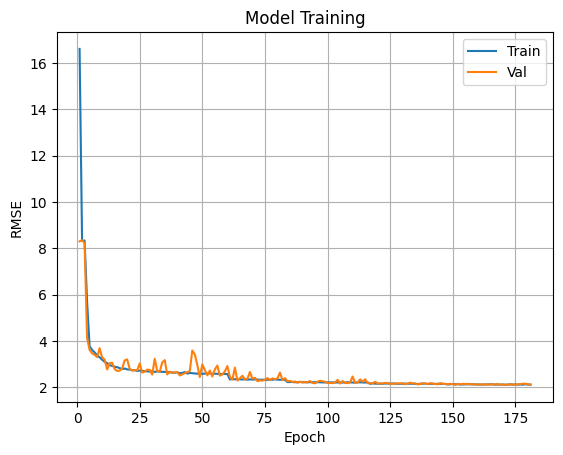

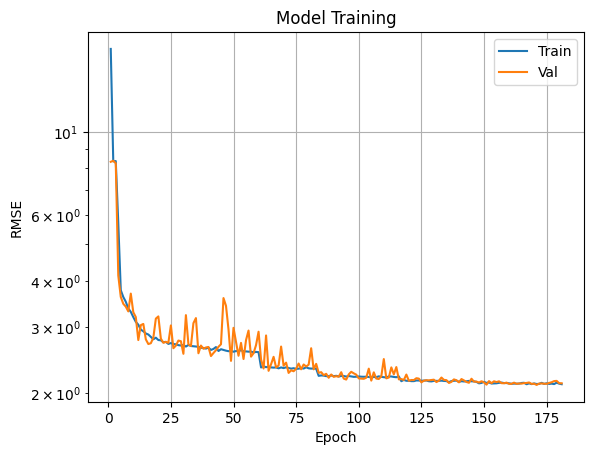

Test loss = 2.121 (last model)
Test loss = 2.156 (best model)


In [25]:
model = Network(
    n_blocks=5,
    latent_size=16,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 4.215, val = 2.719*, lr = 0.01
 2: train = 2.545, val = 2.443*, lr = 0.01
 3: train = 2.375, val = 2.263*, lr = 0.01
 4: train = 2.244, val = 2.322, lr = 0.01
 5: train = 2.183, val = 2.134*, lr = 0.01
 6: train = 2.133, val = 2.118, lr = 0.01
 7: train = 2.092, val = 2.043*, lr = 0.01
 8: train = 2.065, val = 2.098, lr = 0.01
 9: train = 2.008, val = 1.962*, lr = 0.01
 10: train = 1.989, val = 1.945, lr = 0.01
 11: train = 1.949, val = 1.992, lr = 0.01
 12: train = 1.922, val = 1.915*, lr = 0.01
 13: train = 1.924, val = 1.897, lr = 0.01
 14: train = 1.884, val = 1.876*, lr = 0.01
 15: train = 1.875, val = 1.866, lr = 0.01
 16: train = 1.852, val = 1.932, lr = 0.01
 17: train = 1.861, val = 1.894, lr = 0.01
 18: train = 1.836, val = 1.857*, lr = 0.01
 19: train = 1.831, val = 1.847, lr = 0.01
 20: train = 1.8, val = 1.777*, lr = 0.01
 21: train = 1.803, val = 1.863, lr = 0.01
 22: train = 1.793, val = 1.767, lr = 0.01
 23: train = 1.775, val = 1.764, l

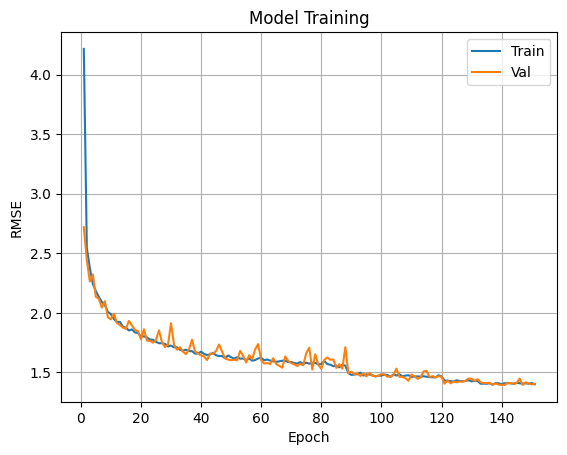

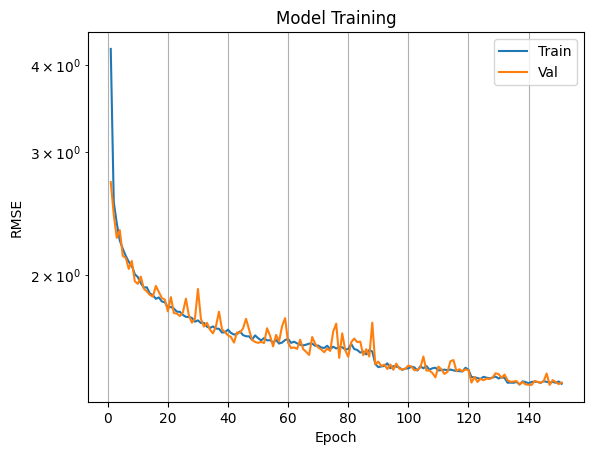

Test loss = 1.399 (last model)
Test loss = 1.415 (best model)


In [33]:
model = Network(
    n_blocks=5,
    latent_size=16,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 481.5, val = 8.352*, lr = 0.01
 2: train = 8.348, val = 8.332, lr = 0.01
 3: train = 8.36, val = 8.338, lr = 0.01
 4: train = 8.329, val = 8.317, lr = 0.01
 5: train = 8.321, val = 8.334, lr = 0.01
 6: train = 8.342, val = 8.3, lr = 0.01
 7: train = 8.324, val = 8.318, lr = 0.01
 8: train = 8.325, val = 8.35, lr = 0.01
 9: train = 8.326, val = 8.33, lr = 0.01
 10: train = 8.348, val = 8.312, lr = 0.01
 11: train = 8.338, val = 8.291, lr = 0.01
 12: train = 8.339, val = 8.362, lr = 0.01
 13: train = 8.327, val = 8.357, lr = 0.01
 14: train = 8.329, val = 8.314, lr = 0.01
 15: train = 8.322, val = 8.314, lr = 0.01
 16: train = 8.328, val = 8.35, lr = 0.01
 17: train = 8.336, val = 8.345, lr = 0.01
 18: train = 8.324, val = 8.316, lr = 0.01
 19: train = 8.343, val = 8.345, lr = 0.01
 20: train = 8.348, val = 8.306, lr = 0.01
 21: train = 8.33, val = 8.337, lr = 0.01
 22: train = 8.335, val = 8.335, lr = 0.005
 23: train = 8.344, val = 8.331, lr = 0.005
 24

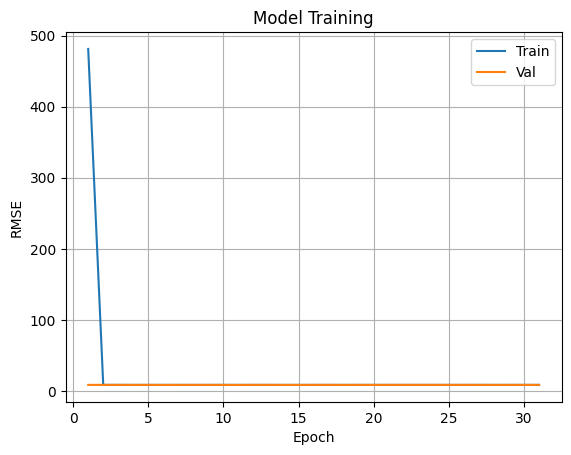

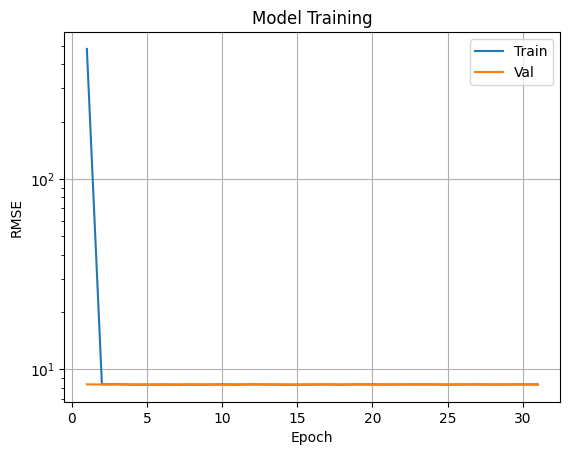

Test loss = 8.341 (last model)
Test loss = 8.335 (best model)


In [26]:
model = Network(
    n_blocks=10,
    latent_size=16,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 6.241, val = 3.942*, lr = 0.01
 2: train = 3.611, val = 5.242, lr = 0.01
 3: train = 3.239, val = 3.277*, lr = 0.01
 4: train = 3.057, val = 2.99*, lr = 0.01
 5: train = 2.989, val = 2.917*, lr = 0.01
 6: train = 2.897, val = 2.698*, lr = 0.01
 7: train = 2.819, val = 2.749, lr = 0.01
 8: train = 2.763, val = 2.779, lr = 0.01
 9: train = 2.684, val = 2.573*, lr = 0.01
 10: train = 2.648, val = 2.553, lr = 0.01
 11: train = 2.615, val = 2.671, lr = 0.01
 12: train = 2.599, val = 2.565, lr = 0.01
 13: train = 2.57, val = 2.708, lr = 0.01
 14: train = 2.56, val = 2.761, lr = 0.01
 15: train = 2.564, val = 2.58, lr = 0.01
 16: train = 2.526, val = 2.897, lr = 0.01
 17: train = 2.517, val = 2.485*, lr = 0.01
 18: train = 2.51, val = 2.584, lr = 0.01
 19: train = 2.507, val = 2.746, lr = 0.01
 20: train = 2.499, val = 2.514, lr = 0.01
 21: train = 2.495, val = 2.411*, lr = 0.01
 22: train = 2.472, val = 2.959, lr = 0.01
 23: train = 2.479, val = 2.501, lr = 0

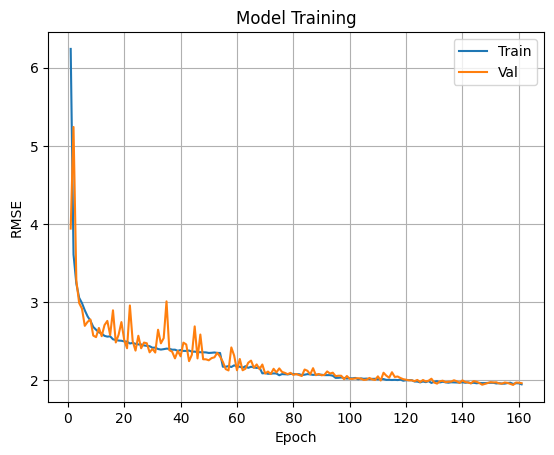

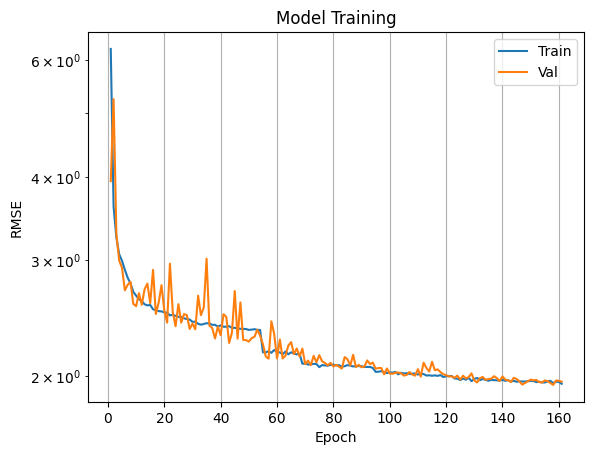

Test loss = 1.968 (last model)
Test loss = 2.008 (best model)


In [27]:
model = Network(
    n_blocks=3,
    latent_size=16,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 10.23, val = 8.343*, lr = 0.01
 2: train = 8.319, val = 8.367, lr = 0.01
 3: train = 8.325, val = 8.292, lr = 0.01
 4: train = 7.89, val = 4.645*, lr = 0.01
 5: train = 4.022, val = 3.555*, lr = 0.01
 6: train = 3.612, val = 3.568, lr = 0.01
 7: train = 3.499, val = 3.39*, lr = 0.01
 8: train = 3.318, val = 3.255*, lr = 0.01
 9: train = 3.222, val = 3.431, lr = 0.01
 10: train = 3.158, val = 3.103*, lr = 0.01
 11: train = 3.089, val = 2.999*, lr = 0.01
 12: train = 3.042, val = 2.857*, lr = 0.01
 13: train = 3.003, val = 2.922, lr = 0.01
 14: train = 2.964, val = 2.947, lr = 0.01
 15: train = 2.931, val = 2.787*, lr = 0.01
 16: train = 3.073, val = 2.754*, lr = 0.01
 17: train = 2.862, val = 2.939, lr = 0.01
 18: train = 2.888, val = 2.996, lr = 0.01
 19: train = 2.892, val = 2.821, lr = 0.01
 20: train = 2.871, val = 2.748, lr = 0.01
 21: train = 2.862, val = 2.857, lr = 0.01
 22: train = 2.86, val = 3.35, lr = 0.01
 23: train = 2.854, val = 2.799, lr 

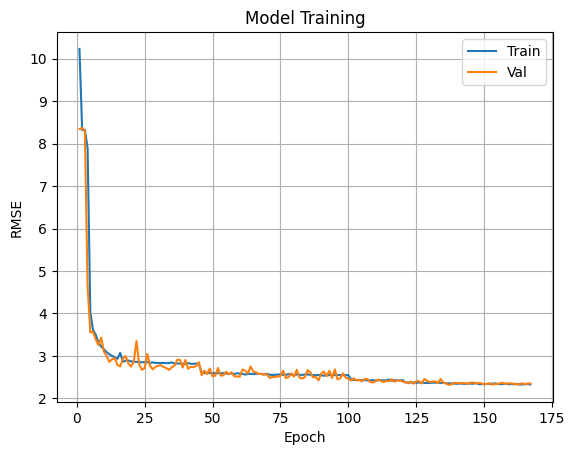

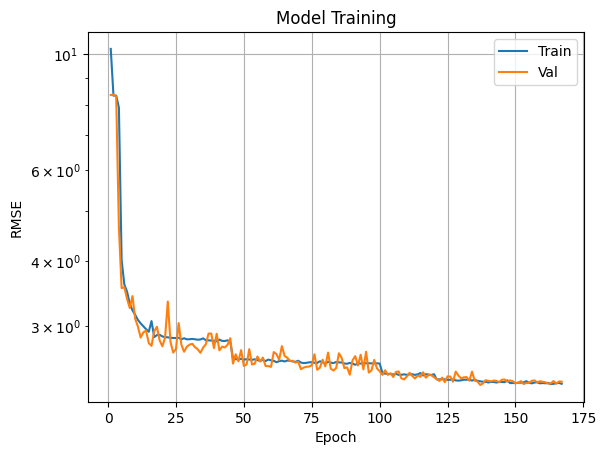

Test loss = 2.325 (last model)
Test loss = 2.341 (best model)


In [28]:
model = Network(
    n_blocks=5,
    latent_size=8,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 32
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 8.816, val = 8.339*, lr = 0.01
 2: train = 8.33, val = 8.328, lr = 0.01
 3: train = 8.335, val = 8.336, lr = 0.01
 4: train = 8.331, val = 8.333, lr = 0.01
 5: train = 8.334, val = 8.338, lr = 0.01
 6: train = 8.332, val = 8.345, lr = 0.01
 7: train = 8.33, val = 8.334, lr = 0.01
 8: train = 8.335, val = 8.338, lr = 0.01
 9: train = 8.332, val = 8.335, lr = 0.01
 10: train = 8.335, val = 8.334, lr = 0.01
 11: train = 8.334, val = 8.33, lr = 0.01
 12: train = 8.33, val = 8.339, lr = 0.01
 13: train = 8.331, val = 8.338, lr = 0.005
 14: train = 8.334, val = 8.335, lr = 0.005
 15: train = 8.335, val = 8.341, lr = 0.005
 16: train = 8.333, val = 8.334, lr = 0.005
 17: train = 8.332, val = 8.34, lr = 0.005
 18: train = 8.334, val = 8.339, lr = 0.005
 19: train = 8.334, val = 8.34, lr = 0.005
 20: train = 8.334, val = 8.331, lr = 0.005
 21: train = 8.334, val = 8.337, lr = 0.005
 22: train = 8.34, val = 8.337, lr = 0.005
 23: train = 8.334, val = 8.331, lr = 

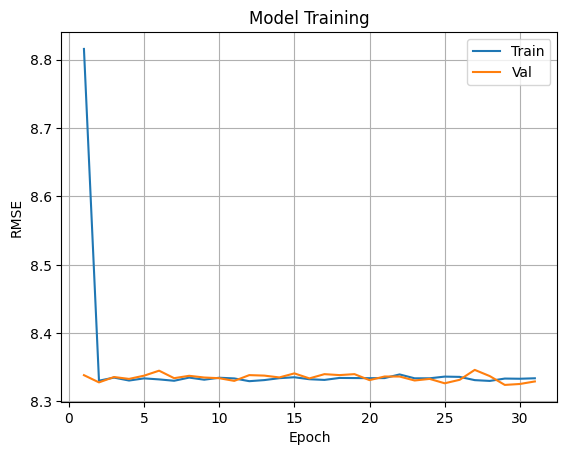

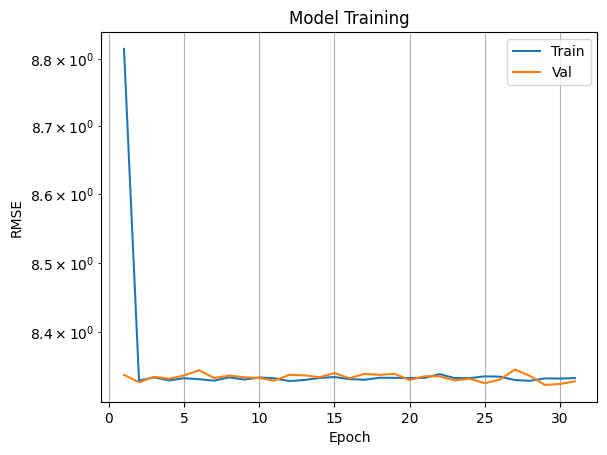

Test loss = 8.329 (last model)
Test loss = 8.326 (best model)


In [29]:
model = Network(
    n_blocks=5,
    latent_size=8,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 30, 30
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 8.407, val = 8.372*, lr = 0.01
 2: train = 8.321, val = 8.373, lr = 0.01
 3: train = 8.321, val = 8.265*, lr = 0.01
 4: train = 4.876, val = 3.597*, lr = 0.01
 5: train = 3.407, val = 3.767, lr = 0.01
 6: train = 3.209, val = 3.448*, lr = 0.01
 7: train = 3.084, val = 3.221*, lr = 0.01
 8: train = 3.046, val = 3.616, lr = 0.01
 9: train = 3.038, val = 3.548, lr = 0.01
 10: train = 2.983, val = 3.401, lr = 0.01
 11: train = 2.949, val = 3.069*, lr = 0.01
 12: train = 2.963, val = 3.018*, lr = 0.01
 13: train = 2.902, val = 2.901*, lr = 0.01
 14: train = 2.905, val = 2.96, lr = 0.01
 15: train = 2.872, val = 2.992, lr = 0.01
 16: train = 2.886, val = 2.779*, lr = 0.01
 17: train = 2.88, val = 2.868, lr = 0.01
 18: train = 2.884, val = 2.997, lr = 0.01
 19: train = 2.875, val = 2.985, lr = 0.01
 20: train = 2.853, val = 2.831, lr = 0.01
 21: train = 2.853, val = 2.961, lr = 0.01
 22: train = 2.851, val = 3.118, lr = 0.01
 23: train = 2.856, val = 3.033, lr

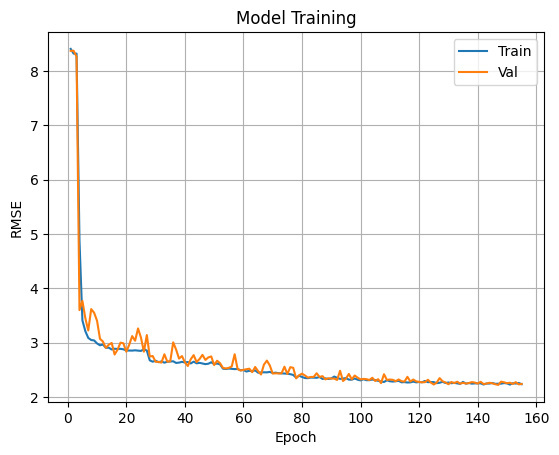

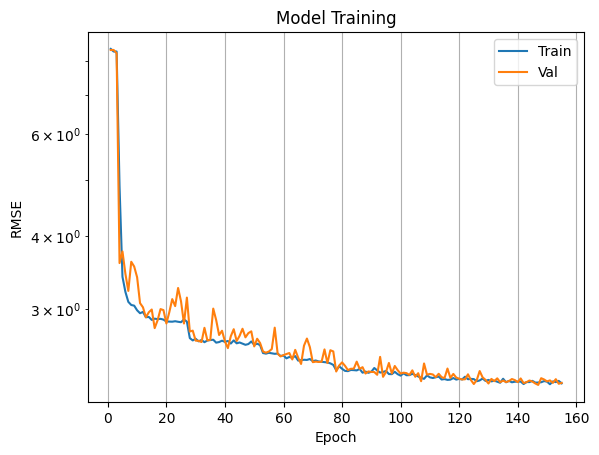

Test loss = 2.253 (last model)
Test loss = 2.265 (best model)


In [30]:
model = Network(
    n_blocks=5,
    latent_size=8,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 5, 5
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 5.799, val = 5.02*, lr = 0.001
 2: train = 4.777, val = 4.512*, lr = 0.001
 3: train = 4.252, val = 4.08*, lr = 0.001
 4: train = 3.925, val = 3.779*, lr = 0.001
 5: train = 3.758, val = 3.769, lr = 0.001
 6: train = 3.626, val = 3.574*, lr = 0.001
 7: train = 3.562, val = 3.584, lr = 0.001
 8: train = 3.49, val = 3.481*, lr = 0.001
 9: train = 3.433, val = 3.366*, lr = 0.001
 10: train = 3.391, val = 3.425, lr = 0.001
 11: train = 3.326, val = 3.298*, lr = 0.001
 12: train = 3.289, val = 3.277, lr = 0.001
 13: train = 3.256, val = 3.276, lr = 0.001
 14: train = 3.221, val = 3.155*, lr = 0.001
 15: train = 3.172, val = 3.209, lr = 0.001
 16: train = 3.147, val = 3.124, lr = 0.001
 17: train = 3.127, val = 3.085*, lr = 0.001
 18: train = 3.087, val = 3.059, lr = 0.001
 19: train = 3.066, val = 3.041*, lr = 0.001
 20: train = 3.047, val = 3.073, lr = 0.001
 21: train = 3.016, val = 2.972*, lr = 0.001
 22: train = 2.98, val = 2.951, lr = 0.001
 23: train =

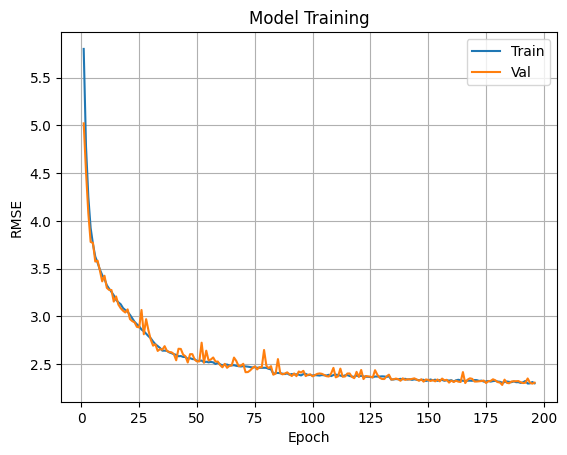

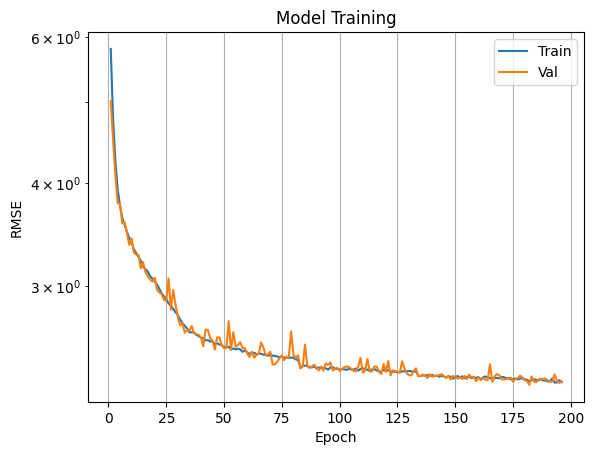

Test loss = 2.324 (last model)
Test loss = 2.328 (best model)


In [31]:
model = Network(
    n_blocks=5,
    latent_size=8,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 5.381, val = 4.639*, lr = 0.001
 2: train = 4.354, val = 4.136*, lr = 0.001
 3: train = 4.032, val = 3.911*, lr = 0.001
 4: train = 3.868, val = 3.982, lr = 0.001
 5: train = 3.769, val = 3.736*, lr = 0.001
 6: train = 3.692, val = 3.85, lr = 0.001
 7: train = 3.606, val = 3.578*, lr = 0.001
 8: train = 3.539, val = 3.631, lr = 0.001
 9: train = 3.481, val = 3.43*, lr = 0.001
 10: train = 3.441, val = 3.366*, lr = 0.001
 11: train = 3.397, val = 3.387, lr = 0.001
 12: train = 3.376, val = 3.357, lr = 0.001
 13: train = 3.345, val = 3.337, lr = 0.001
 14: train = 3.328, val = 3.338, lr = 0.001
 15: train = 3.311, val = 3.271*, lr = 0.001
 16: train = 3.286, val = 3.316, lr = 0.001
 17: train = 3.254, val = 3.251, lr = 0.001
 18: train = 3.22, val = 3.167*, lr = 0.001
 19: train = 3.199, val = 3.176, lr = 0.001
 20: train = 3.176, val = 3.209, lr = 0.001
 21: train = 3.135, val = 3.157, lr = 0.001
 22: train = 3.136, val = 3.097*, lr = 0.001
 23: train = 

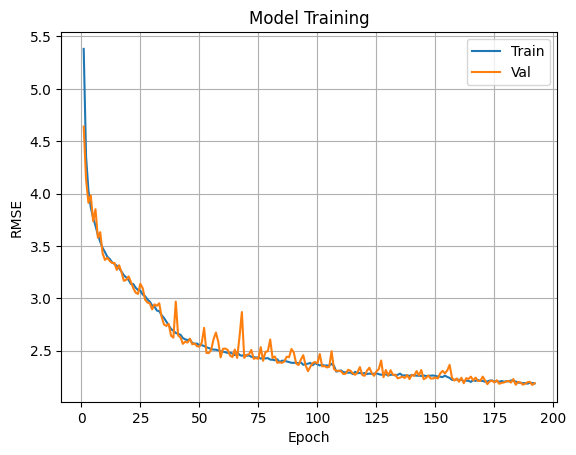

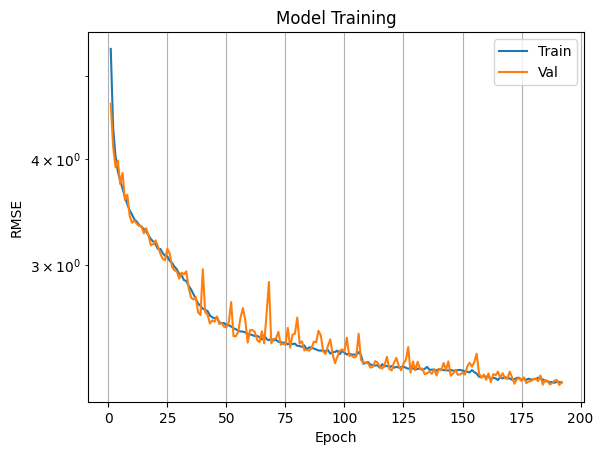

Test loss = 2.181 (last model)
Test loss = 2.192 (best model)


In [32]:
model = Network(
    n_blocks=5,
    latent_size=8,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 4.239, val = 2.802*, lr = 0.01
 2: train = 2.594, val = 2.386*, lr = 0.01
 3: train = 2.359, val = 2.309*, lr = 0.01
 4: train = 2.279, val = 2.264*, lr = 0.01
 5: train = 2.228, val = 2.218*, lr = 0.01
 6: train = 2.197, val = 2.166*, lr = 0.01
 7: train = 2.158, val = 2.141*, lr = 0.01
 8: train = 2.101, val = 2.064*, lr = 0.01
 9: train = 2.073, val = 2.016*, lr = 0.01
 10: train = 2.046, val = 1.999, lr = 0.01
 11: train = 2.006, val = 2.096, lr = 0.01
 12: train = 1.973, val = 1.991*, lr = 0.01
 13: train = 1.956, val = 1.947*, lr = 0.01
 14: train = 1.935, val = 2.148, lr = 0.01
 15: train = 1.922, val = 1.876*, lr = 0.01
 16: train = 1.876, val = 1.865, lr = 0.01
 17: train = 1.87, val = 1.865, lr = 0.01
 18: train = 1.858, val = 1.822*, lr = 0.01
 19: train = 1.83, val = 1.813, lr = 0.01
 20: train = 1.829, val = 1.813, lr = 0.01
 21: train = 1.821, val = 1.785*, lr = 0.01
 22: train = 1.807, val = 1.777, lr = 0.01
 23: train = 1.79, val = 1.796

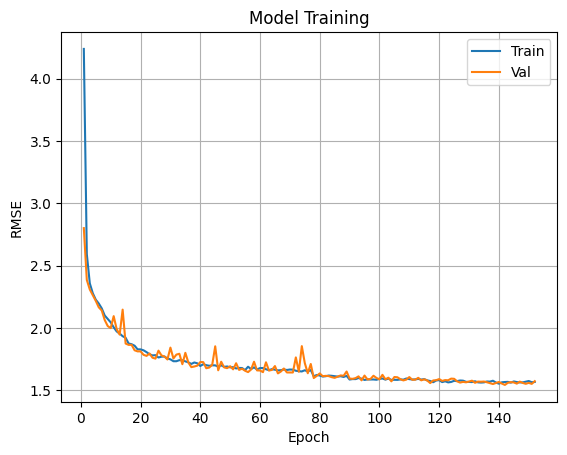

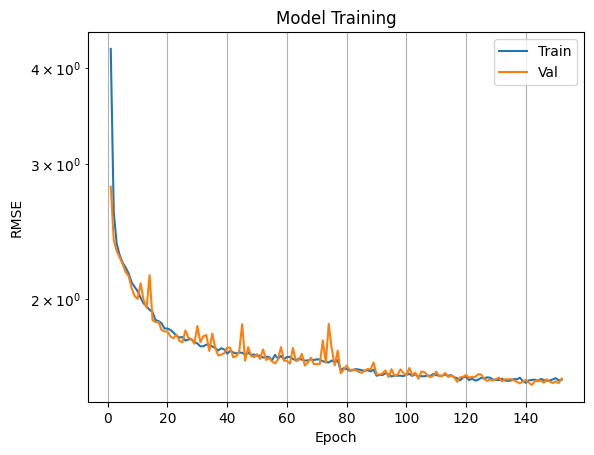

Test loss = 1.569 (last model)
Test loss = 1.56 (best model)


In [73]:
model = Network(
    n_blocks=3,
    latent_size=16,
    activation=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

### Tests 02

=> Starting training
 1: train = 3.973, val = 2.99*, lr = 0.01
 2: train = 2.779, val = 2.601*, lr = 0.01
 3: train = 2.494, val = 2.41*, lr = 0.01
 4: train = 2.382, val = 2.313*, lr = 0.01
 5: train = 2.313, val = 2.274*, lr = 0.01
 6: train = 2.248, val = 2.212*, lr = 0.01
 7: train = 2.205, val = 2.127*, lr = 0.01
 8: train = 2.14, val = 2.164, lr = 0.01
 9: train = 2.12, val = 2.046*, lr = 0.01
 10: train = 2.075, val = 2.315, lr = 0.01
 11: train = 2.046, val = 2.069, lr = 0.01
 12: train = 2.014, val = 1.993*, lr = 0.01
 13: train = 2.007, val = 2.069, lr = 0.01
 14: train = 1.985, val = 1.979, lr = 0.01
 15: train = 1.969, val = 2.055, lr = 0.01
 16: train = 1.97, val = 2.033, lr = 0.01
 17: train = 1.952, val = 1.917*, lr = 0.01
 18: train = 1.937, val = 1.922, lr = 0.01
 19: train = 1.948, val = 1.956, lr = 0.01
 20: train = 1.934, val = 1.943, lr = 0.01
 21: train = 1.913, val = 2.024, lr = 0.01
 22: train = 1.907, val = 1.874*, lr = 0.01
 23: train = 1.91, val = 1.877, lr =

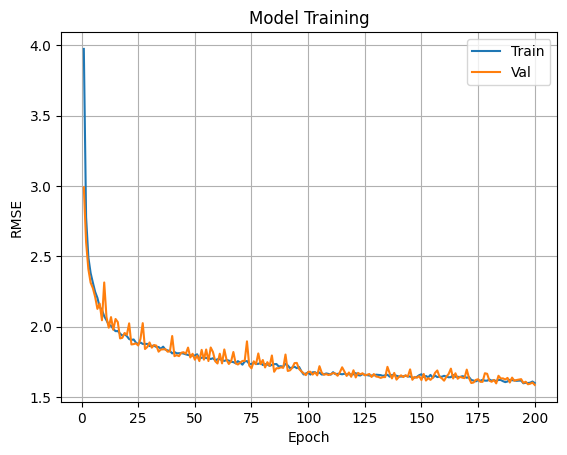

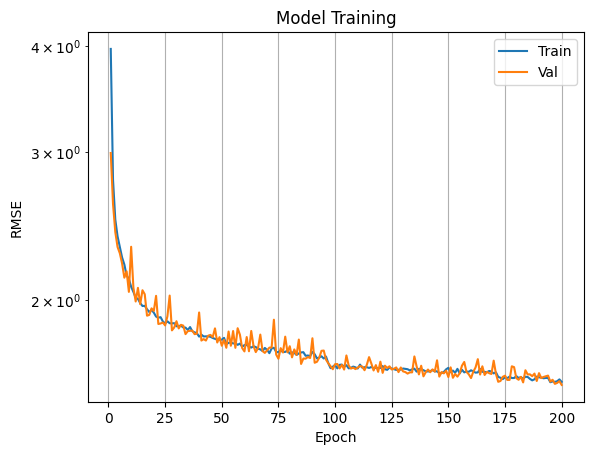

Test loss = 1.601 (last model)
Test loss = 1.614 (best model)


In [60]:
model = Network(
    n_blocks=3,
    latent_size=16,
    activation=True,
    use_residual=True)
loss_fn = nn.MSELoss()

ni, nj = 10, 10
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 3.652, val = 2.816*, lr = 0.01
 2: train = 2.562, val = 2.386*, lr = 0.01
 3: train = 2.338, val = 2.354*, lr = 0.01
 4: train = 2.221, val = 2.191*, lr = 0.01
 5: train = 2.15, val = 2.103*, lr = 0.01
 6: train = 2.096, val = 2.091, lr = 0.01
 7: train = 2.087, val = 2.026*, lr = 0.01
 8: train = 2.037, val = 2.035, lr = 0.01
 9: train = 2.027, val = 1.978*, lr = 0.01
 10: train = 2.006, val = 1.99, lr = 0.01
 11: train = 1.973, val = 1.969, lr = 0.01
 12: train = 1.956, val = 1.929*, lr = 0.01
 13: train = 1.957, val = 1.939, lr = 0.01
 14: train = 1.954, val = 1.966, lr = 0.01
 15: train = 1.931, val = 1.899*, lr = 0.01
 16: train = 1.891, val = 1.925, lr = 0.01
 17: train = 1.907, val = 1.917, lr = 0.01
 18: train = 1.898, val = 1.917, lr = 0.01
 19: train = 1.879, val = 1.879*, lr = 0.01
 20: train = 1.891, val = 1.798*, lr = 0.01
 21: train = 1.883, val = 1.832, lr = 0.01
 22: train = 1.869, val = 1.912, lr = 0.01
 23: train = 1.853, val = 1.861, 

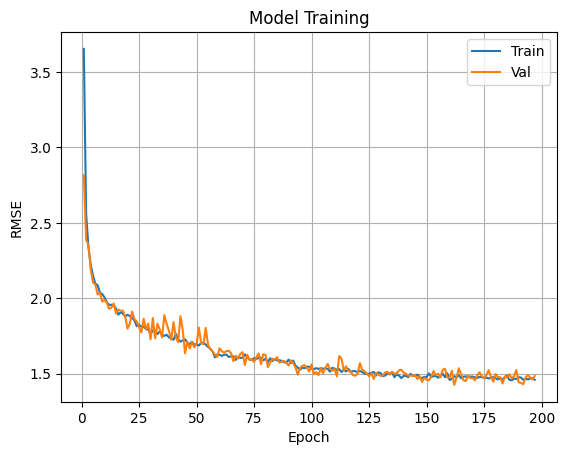

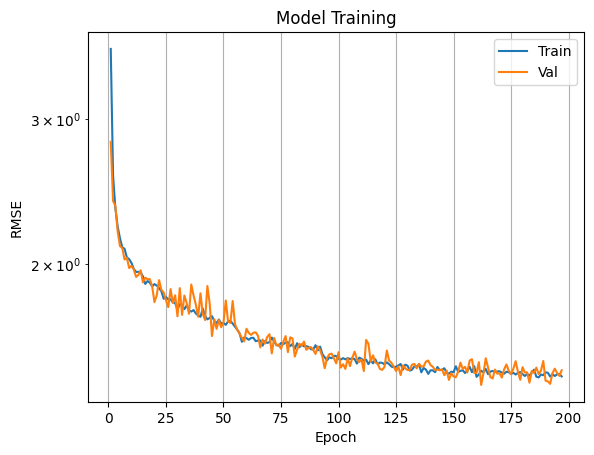

Test loss = 1.493 (last model)
Test loss = 1.464 (best model)


In [62]:
model = Network(
    n_blocks=3,
    latent_size=16,
    activation=True,
    use_residual=True)
loss_fn = nn.MSELoss()

ni, nj = 5, 5
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 3.447, val = 2.487*, lr = 0.01
 2: train = 2.281, val = 2.114*, lr = 0.01
 3: train = 2.087, val = 2.048*, lr = 0.01
 4: train = 1.993, val = 1.942*, lr = 0.01
 5: train = 1.928, val = 1.903*, lr = 0.01
 6: train = 1.9, val = 1.924, lr = 0.01
 7: train = 1.822, val = 1.82*, lr = 0.01
 8: train = 1.813, val = 1.797*, lr = 0.01
 9: train = 1.769, val = 1.71*, lr = 0.01
 10: train = 1.752, val = 1.771, lr = 0.01
 11: train = 1.721, val = 1.787, lr = 0.01
 12: train = 1.738, val = 1.732, lr = 0.01
 13: train = 1.687, val = 1.672*, lr = 0.01
 14: train = 1.674, val = 1.67, lr = 0.01
 15: train = 1.682, val = 1.637*, lr = 0.01
 16: train = 1.653, val = 1.608*, lr = 0.01
 17: train = 1.637, val = 1.626, lr = 0.01
 18: train = 1.629, val = 1.659, lr = 0.01
 19: train = 1.61, val = 1.628, lr = 0.01
 20: train = 1.621, val = 1.604, lr = 0.01
 21: train = 1.589, val = 1.569*, lr = 0.01
 22: train = 1.585, val = 1.628, lr = 0.01
 23: train = 1.567, val = 1.541*, lr

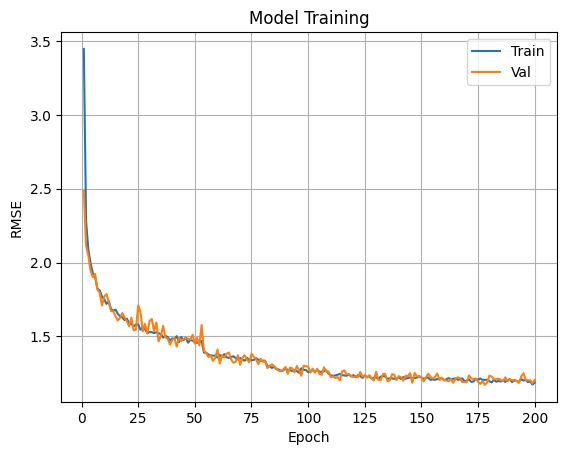

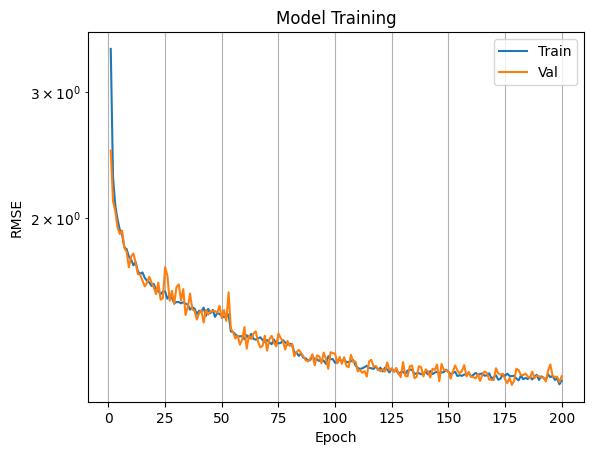

Test loss = 1.233 (last model)
Test loss = 1.231 (best model)


In [63]:
model = Network(
    n_blocks=3,
    latent_size=32,
    activation=True,
    use_residual=True)
loss_fn = nn.MSELoss()

ni, nj = 5, 5
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 4.433, val = 3.013*, lr = 0.01
 2: train = 2.871, val = 2.859*, lr = 0.01
 3: train = 2.775, val = 2.717*, lr = 0.01
 4: train = 2.72, val = 2.693, lr = 0.01
 5: train = 2.685, val = 2.799, lr = 0.01
 6: train = 2.661, val = 2.653*, lr = 0.01
 7: train = 2.643, val = 2.553*, lr = 0.01
 8: train = 2.605, val = 2.626, lr = 0.01
 9: train = 2.599, val = 2.608, lr = 0.01
 10: train = 2.581, val = 2.589, lr = 0.01
 11: train = 2.533, val = 2.573, lr = 0.01
 12: train = 2.531, val = 2.526*, lr = 0.01
 13: train = 2.552, val = 2.534, lr = 0.01
 14: train = 2.517, val = 2.54, lr = 0.01
 15: train = 2.542, val = 2.674, lr = 0.01
 16: train = 2.524, val = 2.493*, lr = 0.01
 17: train = 2.521, val = 2.521, lr = 0.01
 18: train = 2.514, val = 2.6, lr = 0.01
 19: train = 2.53, val = 2.509, lr = 0.01
 20: train = 2.512, val = 2.543, lr = 0.01
 21: train = 2.525, val = 2.474, lr = 0.01
 22: train = 2.504, val = 2.633, lr = 0.01
 23: train = 2.501, val = 2.501, lr = 0.

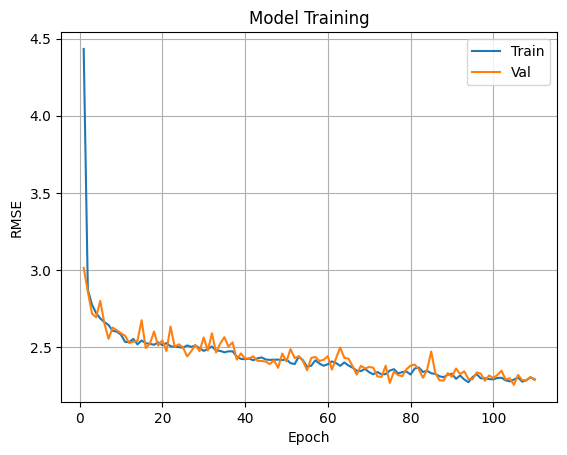

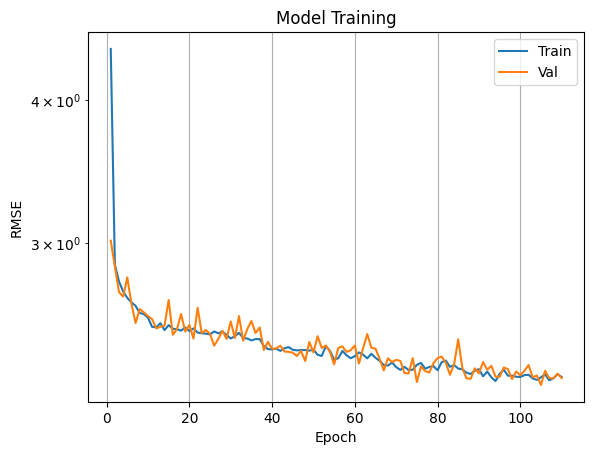

Test loss = 2.27 (last model)
Test loss = 2.34 (best model)


In [77]:
model = Network(
    n_blocks=3,
    latent_size=64,
    activation=True,
    use_residual=True)
loss_fn = nn.MSELoss()

ni, nj = 5, 5
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

=> Starting training
 1: train = 4.53, val = 4.283*, lr = 0.01
 2: train = 4.3, val = 4.268, lr = 0.01
 3: train = 4.332, val = 4.438, lr = 0.01
 4: train = 4.314, val = 4.272, lr = 0.01
 5: train = 4.292, val = 4.297, lr = 0.01
 6: train = 4.308, val = 4.285, lr = 0.01
 7: train = 4.311, val = 4.341, lr = 0.01
 8: train = 4.289, val = 4.264, lr = 0.01
 9: train = 4.29, val = 4.28, lr = 0.01
 10: train = 4.295, val = 4.329, lr = 0.01
 11: train = 4.27, val = 4.288, lr = 0.01
 12: train = 4.288, val = 4.287, lr = 0.01
 13: train = 4.286, val = 4.231*, lr = 0.01
 14: train = 4.288, val = 4.268, lr = 0.01
 15: train = 4.291, val = 4.27, lr = 0.01
 16: train = 4.293, val = 4.27, lr = 0.01
 17: train = 4.29, val = 4.324, lr = 0.01
 18: train = 4.296, val = 4.3, lr = 0.01
 19: train = 4.262, val = 4.308, lr = 0.01
 20: train = 4.283, val = 4.315, lr = 0.01
 21: train = 4.277, val = 4.283, lr = 0.01
 22: train = 4.268, val = 4.292, lr = 0.01
 23: train = 4.286, val = 4.252, lr = 0.01
 24: tra

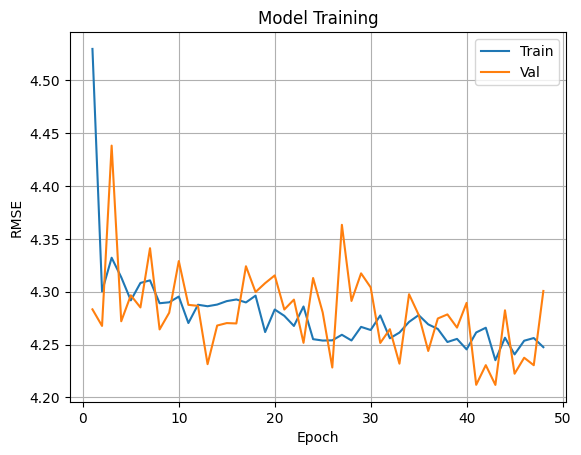

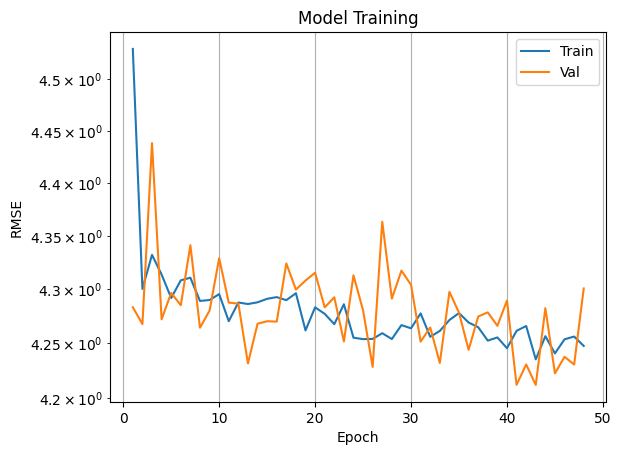

Test loss = 4.287 (last model)
Test loss = 4.342 (best model)


In [87]:
model = Network(
    n_blocks=3,
    latent_size=32,
    activation=False,
    use_residual=True)
loss_fn = nn.MSELoss()

ni, nj = 5, 5
data_train = CustomDataset(ni, nj, 10000)
data_val = CustomDataset(ni, nj, 2000)
data_test = CustomDataset(ni, nj, 2000)
batch_size = 64
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.5, patience=10)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn, scheduler)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

### Tests 03: Batch Normalization + Inception Block

In [24]:
best01 = new_dict(args_vanilla,
                  {'file_name': 'best01',
                   'n_blocks': 3,
                   'latent_size': 16,
                   'use_residual': True,
                   'ni': 5,
                   'nj': 5,
                   'optimizer': torch.optim.Adam})

In [ ]:
model = new_test(best01)
test_sample(model)

In [25]:
best01_batch_norm = new_dict(best01,
                             {'file_name':'best01_batch_norm',
                              'batch_norm': True})

In [ ]:
model = new_test(best01_batch_norm)
test_sample(model)

In [26]:
best01_inception = new_dict(best01_batch_norm,
                            {'file_name':'best01_inception',
                             'use_inception': True})

In [ ]:
model = new_test(best01_inception)
test_sample(model)

In [27]:
best01_deep_res = new_dict(best01_inception,
                           {'file_name':'best01_deep_res',
                            'deep_residual': True})

In [ ]:
model = new_test(best01_deep_res)
test_sample(model)

In [36]:
best01_inception2 = new_dict(best01_inception,
                             {'file_name':'best01_inception2',
                              'n_blocks':5,
                              'deep_residual': True})

=> Starting training
 1: train = 3.838, val = 2.987*, lr = 0.01
 2: train = 2.607, val = 2.439*, lr = 0.01
 3: train = 2.326, val = 2.154*, lr = 0.01
 4: train = 2.155, val = 2.117*, lr = 0.01
 5: train = 2.037, val = 1.994*, lr = 0.01
 6: train = 1.996, val = 1.974*, lr = 0.01
 7: train = 1.972, val = 1.973, lr = 0.01
 8: train = 1.924, val = 1.877*, lr = 0.01
 9: train = 1.887, val = 1.908, lr = 0.01
 10: train = 1.854, val = 1.924, lr = 0.01
 11: train = 1.839, val = 1.874, lr = 0.01
 12: train = 1.822, val = 1.835*, lr = 0.01
 13: train = 1.813, val = 1.801*, lr = 0.01
 14: train = 1.783, val = 1.805, lr = 0.01
 15: train = 1.788, val = 1.763*, lr = 0.01
 16: train = 1.757, val = 1.812, lr = 0.01
 17: train = 1.778, val = 1.716*, lr = 0.01
 18: train = 1.758, val = 1.769, lr = 0.01
 19: train = 1.717, val = 1.734, lr = 0.01
 20: train = 1.733, val = 1.734, lr = 0.01
 21: train = 1.735, val = 1.691*, lr = 0.01
 22: train = 1.714, val = 1.736, lr = 0.01
 23: train = 1.724, val = 1.65

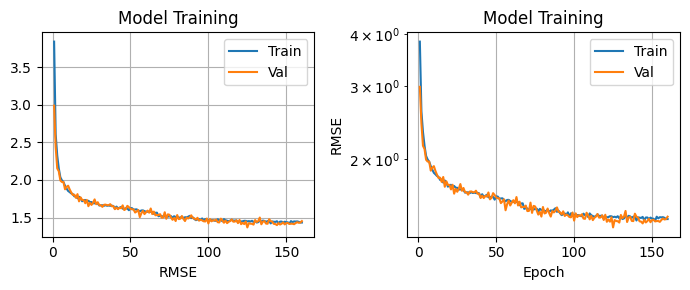

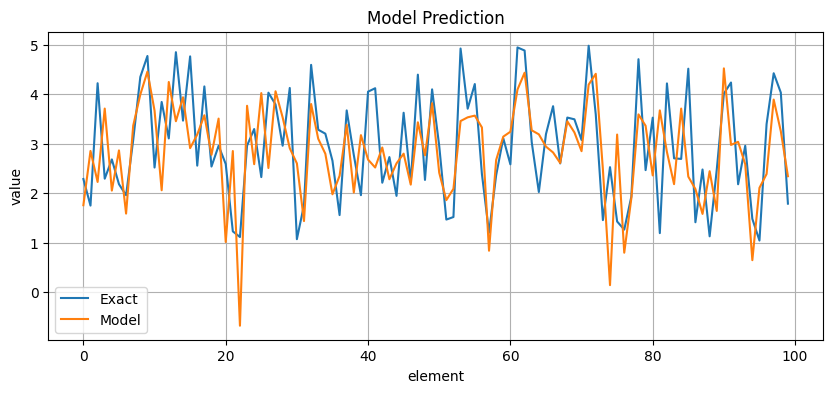

In [37]:
model = new_test(best01_inception2)
test_sample(model)

In [43]:
best01_inception3 = new_dict(best01_inception,
                             {'file_name': 'best01_inception3',
                              'latent_size': 32,
                              'deep_residual': True})

=> Starting training
 1: train = 3.048, val = 2.337*, lr = 0.01
 2: train = 2.129, val = 2.055*, lr = 0.01
 3: train = 1.95, val = 1.873*, lr = 0.01
 4: train = 1.836, val = 1.811*, lr = 0.01
 5: train = 1.751, val = 1.732*, lr = 0.01
 6: train = 1.705, val = 1.701*, lr = 0.01
 7: train = 1.69, val = 1.736, lr = 0.01
 8: train = 1.643, val = 1.705, lr = 0.01
 9: train = 1.644, val = 1.638*, lr = 0.01
 10: train = 1.614, val = 1.608*, lr = 0.01
 11: train = 1.616, val = 1.626, lr = 0.01
 12: train = 1.606, val = 1.587*, lr = 0.01
 13: train = 1.581, val = 1.615, lr = 0.01
 14: train = 1.575, val = 1.572, lr = 0.01
 15: train = 1.581, val = 1.521*, lr = 0.01
 16: train = 1.57, val = 1.599, lr = 0.01
 17: train = 1.546, val = 1.54, lr = 0.01
 18: train = 1.527, val = 1.55, lr = 0.01
 19: train = 1.526, val = 1.479*, lr = 0.01
 20: train = 1.505, val = 1.566, lr = 0.01
 21: train = 1.527, val = 1.502, lr = 0.01
 22: train = 1.498, val = 1.516, lr = 0.01
 23: train = 1.492, val = 1.508, lr 

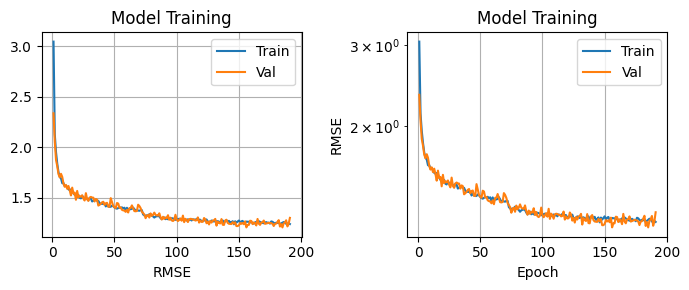

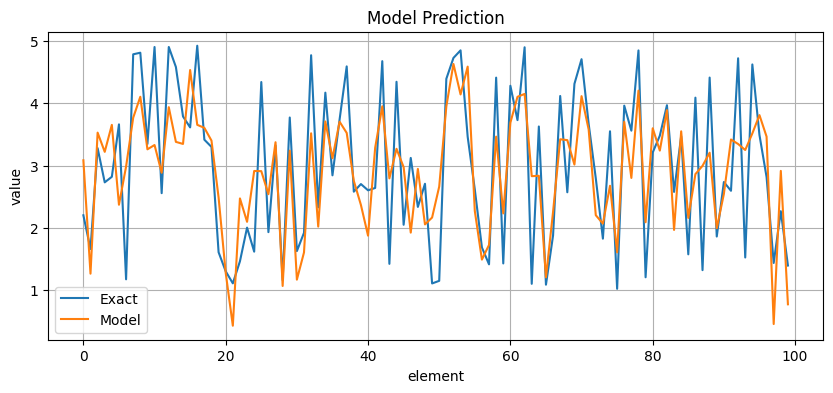

In [44]:
model = new_test(best01_inception3)
test_sample(model)

In [45]:
best01_inception4 = new_dict(best01_inception,
                             {'file_name': 'best01_inception4',
                              'latent_size': 32,
                              'n_blocks':5,
                              'deep_residual': True})

=> Starting training
 1: train = 3.258, val = 2.559*, lr = 0.01
 2: train = 2.258, val = 2.12*, lr = 0.01
 3: train = 1.948, val = 1.967*, lr = 0.01
 4: train = 1.797, val = 1.744*, lr = 0.01
 5: train = 1.715, val = 1.674*, lr = 0.01
 6: train = 1.637, val = 1.586*, lr = 0.01
 7: train = 1.568, val = 1.598, lr = 0.01
 8: train = 1.524, val = 1.464*, lr = 0.01
 9: train = 1.468, val = 1.478, lr = 0.01
 10: train = 1.449, val = 1.411*, lr = 0.01
 11: train = 1.404, val = 1.423, lr = 0.01
 12: train = 1.403, val = 1.398, lr = 0.01
 13: train = 1.384, val = 1.366*, lr = 0.01
 14: train = 1.367, val = 1.359, lr = 0.01
 15: train = 1.345, val = 1.364, lr = 0.01
 16: train = 1.336, val = 1.312*, lr = 0.01
 17: train = 1.34, val = 1.336, lr = 0.01
 18: train = 1.311, val = 1.327, lr = 0.01
 19: train = 1.316, val = 1.327, lr = 0.01
 20: train = 1.325, val = 1.342, lr = 0.01
 21: train = 1.299, val = 1.302, lr = 0.01
 22: train = 1.275, val = 1.296*, lr = 0.01
 23: train = 1.274, val = 1.29, l

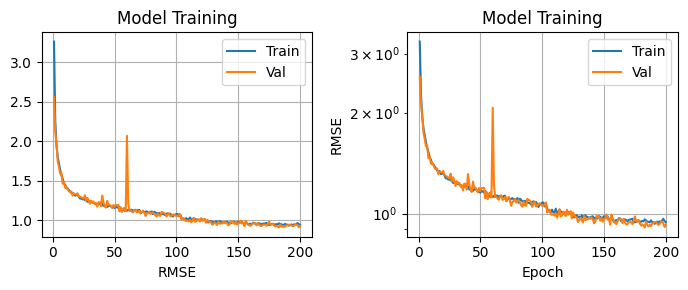

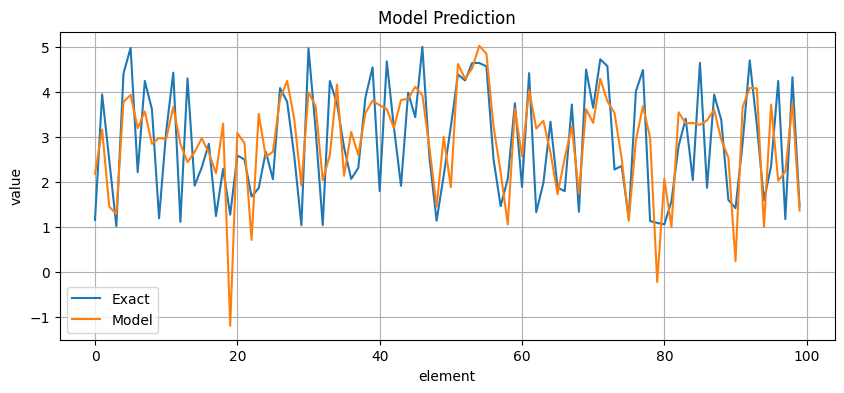

In [46]:
model = new_test(best01_inception4)
test_sample(model)

In [47]:
best01_inception5 = new_dict(best01_inception,
                             {'file_name': 'best01_inception5',
                              'latent_size': 64,
                              'n_blocks':5,
                              'deep_residual': True})

=> Starting training
 1: train = 3.409, val = 21.63*, lr = 0.01
 2: train = 2.056, val = 1.867*, lr = 0.01
 3: train = 1.743, val = 1.8*, lr = 0.01
 4: train = 1.569, val = 1.616*, lr = 0.01
 5: train = 1.485, val = 6.076, lr = 0.01
 6: train = 1.408, val = 1.472*, lr = 0.01
 7: train = 1.324, val = 1.316*, lr = 0.01
 8: train = 1.28, val = 1.282*, lr = 0.01
 9: train = 1.236, val = 1.308, lr = 0.01
 10: train = 1.213, val = 2.57, lr = 0.01
 11: train = 1.185, val = 1.673, lr = 0.01
 12: train = 1.163, val = 1.153*, lr = 0.01
 13: train = 1.112, val = 30.38, lr = 0.01
 14: train = 1.105, val = 1.142*, lr = 0.01
 15: train = 1.09, val = 1.089*, lr = 0.01
 16: train = 1.076, val = 1.147, lr = 0.01
 17: train = 1.04, val = 1.078*, lr = 0.01
 18: train = 1.038, val = 1.073, lr = 0.01
 19: train = 1.045, val = 0.9916*, lr = 0.01
 20: train = 1.008, val = 1.01, lr = 0.01
 21: train = 1.013, val = 1.046, lr = 0.01
 22: train = 1.01, val = 1.028, lr = 0.01
 23: train = 0.9995, val = 1.015, lr 

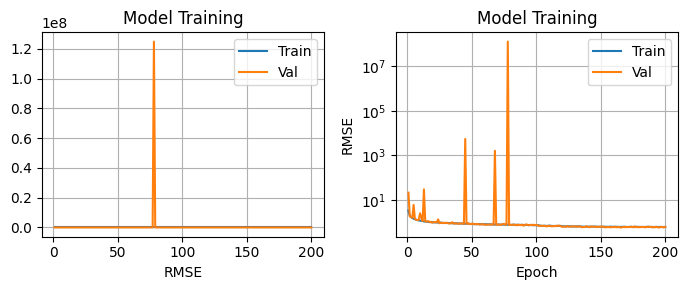

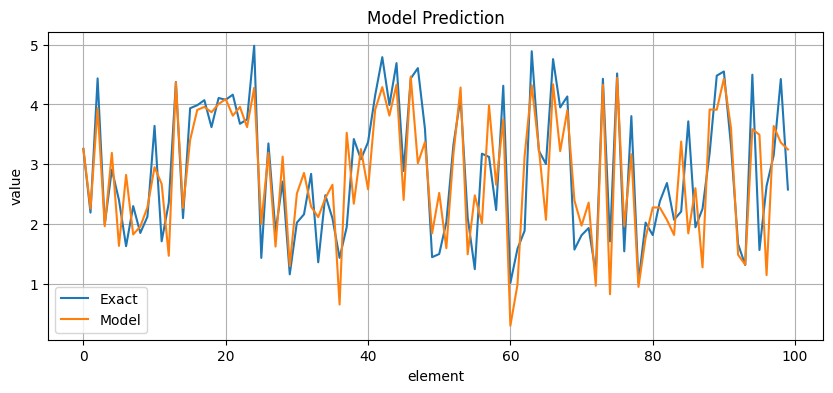

In [48]:
model = new_test(best01_inception5)
test_sample(model)

In [49]:
best01_inception6 = new_dict(best01_inception,
                             {'file_name': 'best01_inception6',
                              'latent_size': 128,
                              'n_blocks':5,
                              'deep_residual': True})

best01_inception7 = new_dict(best01_inception,
                             {'file_name': 'best01_inception7',
                              'latent_size': 64,
                              'n_blocks':10,
                              'deep_residual': True})

best01_inception8 = new_dict(best01_inception,
                             {'file_name': 'best01_inception8',
                              'latent_size': 128,
                              'n_blocks':16,
                              'deep_residual': True})

=> Starting training
 1: train = 3.807, val = 1951*, lr = 0.01
 2: train = 2.074, val = 281.2*, lr = 0.01
 3: train = 1.734, val = 1.601*, lr = 0.01
 4: train = 1.529, val = 1.519*, lr = 0.01
 5: train = 1.408, val = 1.375*, lr = 0.01
 6: train = 1.29, val = 1.287*, lr = 0.01
 7: train = 1.24, val = 1.22*, lr = 0.01
 8: train = 1.178, val = 1.138*, lr = 0.01
 9: train = 1.129, val = 1.095*, lr = 0.01
 10: train = 1.104, val = 1752, lr = 0.01
 11: train = 1.064, val = 2.618, lr = 0.01
 12: train = 1.044, val = 1.013*, lr = 0.01
 13: train = 1.039, val = 5.262e+07, lr = 0.01
 14: train = 0.9958, val = 1.047, lr = 0.01
 15: train = 0.9986, val = 0.9699*, lr = 0.01
 16: train = 0.9786, val = 0.9631, lr = 0.01
 17: train = 0.9748, val = 0.9511*, lr = 0.01
 18: train = 0.9624, val = 0.9292*, lr = 0.01
 19: train = 0.9348, val = 0.995, lr = 0.01
 20: train = 0.9145, val = 0.8905*, lr = 0.01
 21: train = 0.9206, val = 0.8924, lr = 0.01
 22: train = 0.9072, val = 0.9338, lr = 0.01
 23: train = 

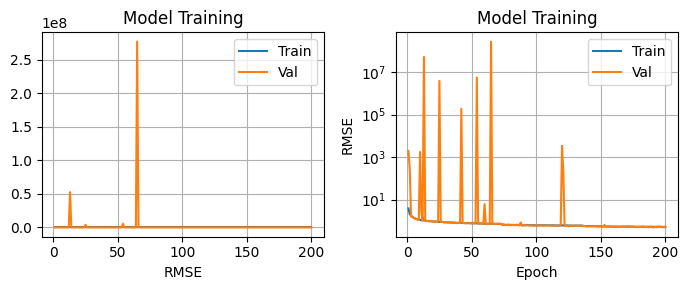

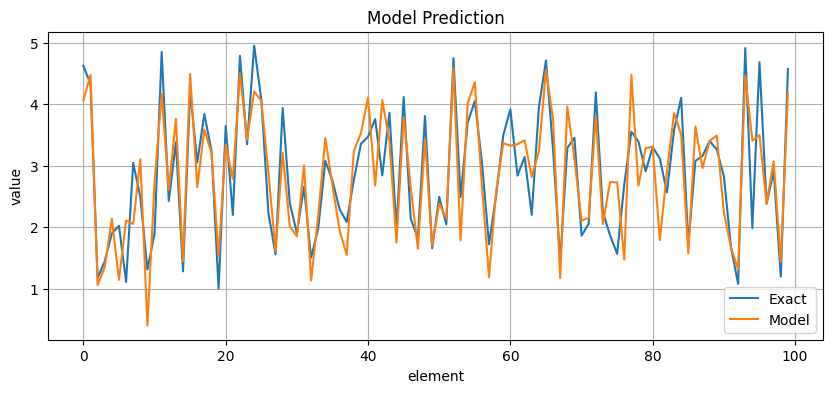

In [50]:
model = new_test(best01_inception6)
test_sample(model)

=> Starting training
 1: train = 4.302, val = 2.295e+10*, lr = 0.01
 2: train = 2.33, val = 3.765e+04*, lr = 0.01
 3: train = 1.865, val = 3.05e+11, lr = 0.01
 4: train = 1.604, val = 3642*, lr = 0.01
 5: train = 1.453, val = 1.342*, lr = 0.01
 6: train = 1.308, val = 1076, lr = 0.01
 7: train = 1.222, val = 37.63, lr = 0.01
 8: train = 1.157, val = 2.92, lr = 0.01
 9: train = 1.103, val = 1.102*, lr = 0.01
 10: train = 1.06, val = 1.299e+05, lr = 0.01
 11: train = 1.025, val = 1.059*, lr = 0.01
 12: train = 0.9947, val = 1.006*, lr = 0.01
 13: train = 0.9638, val = 3.543e+04, lr = 0.01
 14: train = 0.9586, val = 1.449e+08, lr = 0.01
 15: train = 0.9437, val = 0.9335*, lr = 0.01
 16: train = 0.9084, val = 9333, lr = 0.01
 17: train = 0.899, val = 3.56e+04, lr = 0.01
 18: train = 0.8856, val = 2.102e+09, lr = 0.01
 19: train = 0.9249, val = 2.145e+07, lr = 0.01
 20: train = 0.8748, val = 3.16e+08, lr = 0.01
 21: train = 0.8591, val = 0.8864*, lr = 0.01
 22: train = 0.8416, val = 822.1, 

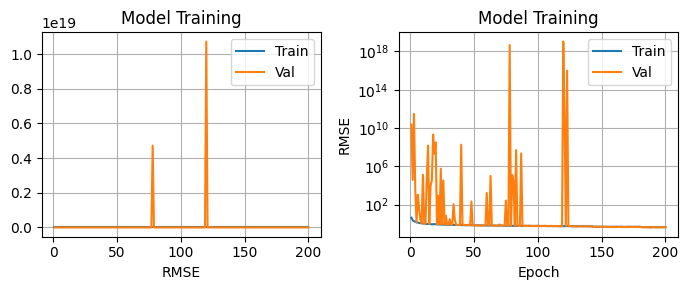

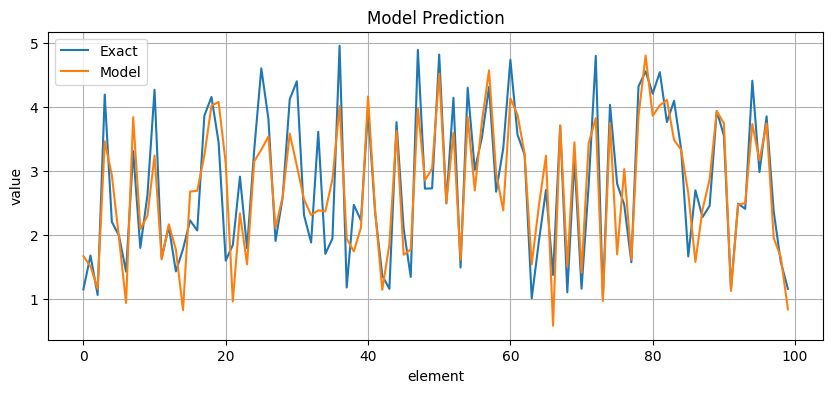

In [51]:
model = new_test(best01_inception7)
test_sample(model)

=> Starting training
 1: train = 8.748, val = 4.521e+20*, lr = 0.01
 2: train = 2.789, val = 2.791e+25, lr = 0.01
 3: train = 2.123, val = 2.894e+19*, lr = 0.01
 4: train = 1.795, val = 1.776e+16*, lr = 0.01
 5: train = 1.603, val = 2.547e+20, lr = 0.01
 6: train = 1.438, val = 1.163e+09*, lr = 0.01
 7: train = 1.317, val = 2.268e+12, lr = 0.01
 8: train = 1.224, val = 1.259*, lr = 0.01
 9: train = 1.126, val = 2.328e+11, lr = 0.01
 10: train = 1.063, val = 3.44e+20, lr = 0.01
 11: train = 1.004, val = 3.73e+16, lr = 0.01
 12: train = 0.9739, val = 1.153e+10, lr = 0.01
 13: train = 0.95, val = 2.182e+12, lr = 0.01
 14: train = 0.8964, val = 3.49e+21, lr = 0.01
 15: train = 0.871, val = 1.018e+19, lr = 0.01
 16: train = 0.8469, val = 2.745e+14, lr = 0.01
 17: train = 0.8216, val = 3.016e+07, lr = 0.01
 18: train = 0.803, val = 7.99e+22, lr = 0.01
 19: train = 0.7805, val = 1.267e+22, lr = 0.005
 20: train = 0.6903, val = 7.191e+20, lr = 0.005
 21: train = 0.6671, val = 9.964e+06, lr = 0

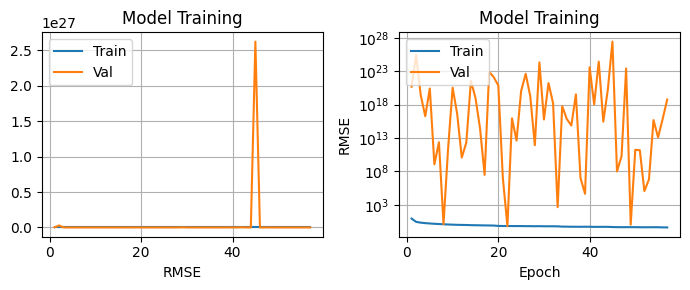

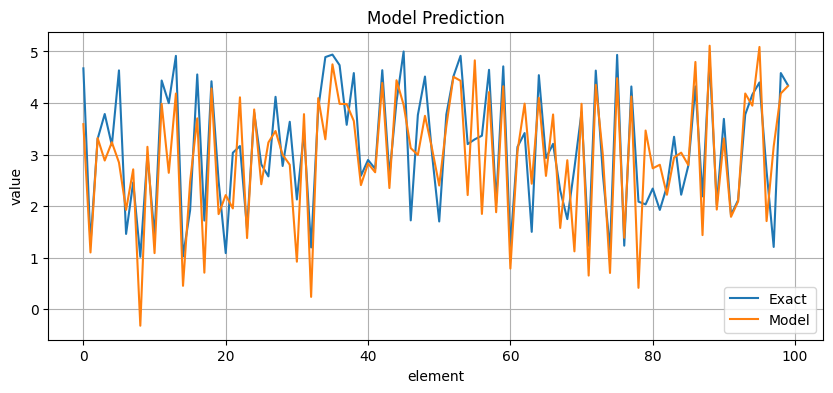

In [52]:
model = new_test(best01_inception8)
test_sample(model)

In [53]:
best01_inception9 = new_dict(best01_inception,
                             {'file_name': 'best01_inception9',
                              'latent_size': 64,
                              'n_blocks':16,
                              'deep_residual': True})

best01_inception10 = new_dict(best01_inception,
                             {'file_name': 'best01_inception10',
                              'latent_size': 64,
                              'n_blocks':32,
                              'deep_residual': True})

=> Starting training
 1: train = 5.049, val = 6.165e+10*, lr = 0.01
 2: train = 2.863, val = 3.405*, lr = 0.01
 3: train = 2.161, val = 1.73e+07, lr = 0.01
 4: train = 1.871, val = 8.334e+16, lr = 0.01
 5: train = 1.662, val = 3.957e+10, lr = 0.01
 6: train = 1.52, val = 1.454*, lr = 0.01
 7: train = 1.365, val = 1.584e+05, lr = 0.01
 8: train = 1.248, val = 4.273e+21, lr = 0.01
 9: train = 1.176, val = 6.545e+18, lr = 0.01
 10: train = 1.1, val = 5.773e+16, lr = 0.01
 11: train = 1.048, val = 1.309e+20, lr = 0.01
 12: train = 0.9882, val = 3.84e+18, lr = 0.01
 13: train = 0.9612, val = 1.104e+16, lr = 0.01
 14: train = 0.9388, val = 1.585e+09, lr = 0.01
 15: train = 0.9167, val = 1.855e+05, lr = 0.01
 16: train = 0.8776, val = 4.857e+16, lr = 0.01
 17: train = 0.8771, val = 4.064e+25, lr = 0.005
 18: train = 0.7675, val = 1.442e+16, lr = 0.005
 19: train = 0.741, val = 4.286e+13, lr = 0.005
 20: train = 0.7218, val = 1.357e+17, lr = 0.005
 21: train = 0.7159, val = 1.508e+14, lr = 0.0

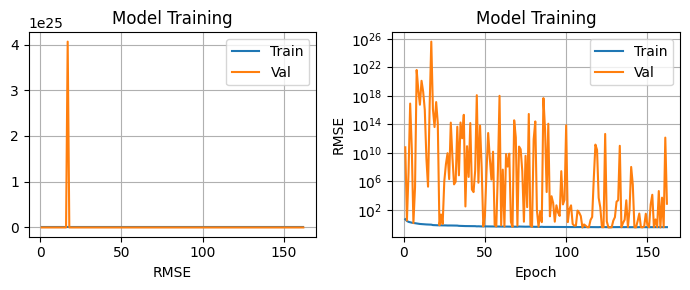

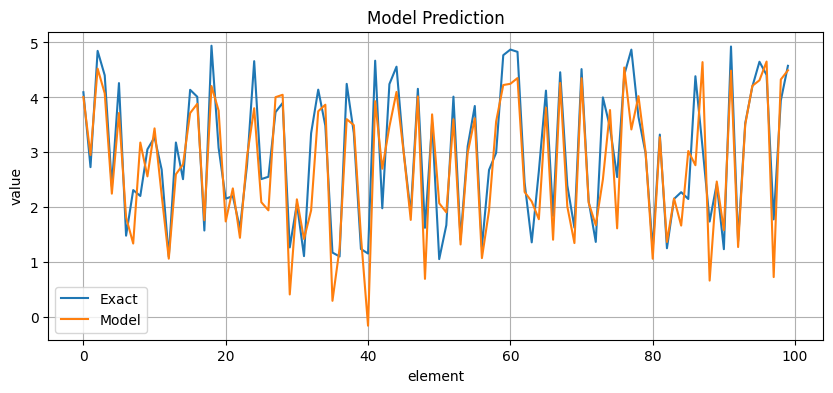

In [54]:
model = new_test(best01_inception9)
test_sample(model)

=> Starting training
 1: train = 9.286, val = 1.282e+30*, lr = 0.01
 2: train = 3.497, val = 7.641e+26*, lr = 0.01
 3: train = 2.734, val = 1.478e+16*, lr = 0.01
 4: train = 2.406, val = 1.658e+22, lr = 0.01
 5: train = 2.14, val = 2.727e+13*, lr = 0.01
 6: train = 1.915, val = 9.41e+25, lr = 0.01
 7: train = 1.727, val = 8.05e+14, lr = 0.01
 8: train = 1.58, val = 2.796e+27, lr = 0.01
 9: train = 1.42, val = 2.577e+10*, lr = 0.01
 10: train = 1.286, val = 4.538e+22, lr = 0.01
 11: train = 1.188, val = inf, lr = 0.01
 12: train = 1.107, val = 3.4e+27, lr = 0.01
 13: train = 1.053, val = 5.077e+22, lr = 0.01
 14: train = 1.013, val = 2.211e+32, lr = 0.01
 15: train = 0.9588, val = inf, lr = 0.01
 16: train = 0.9304, val = 7.649e+32, lr = 0.01
 17: train = 0.9012, val = 5.368e+20, lr = 0.01
 18: train = 0.8677, val = 1.637e+24, lr = 0.01
 19: train = 0.8629, val = inf, lr = 0.01
 20: train = 0.8215, val = inf, lr = 0.005
 21: train = 0.7218, val = inf, lr = 0.005
 22: train = 0.7074, val

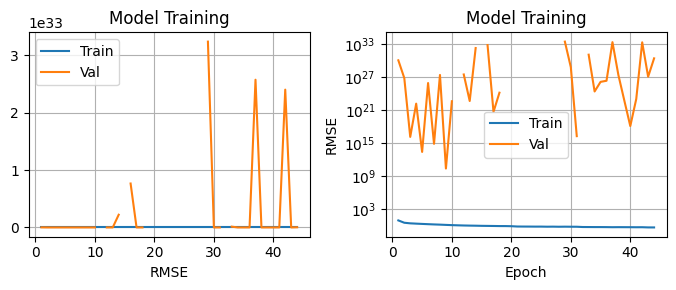

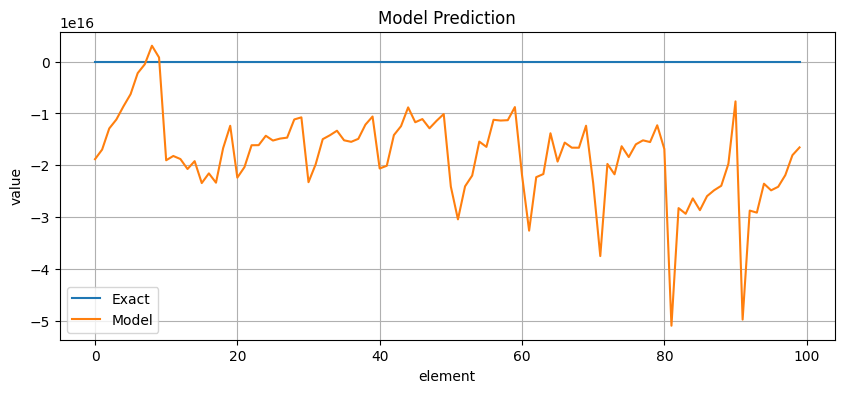

In [55]:
model = new_test(best01_inception10)
test_sample(model)

### Model Test

In [57]:
args, train_loss, val_loss, model = load_test('best01_inception9')

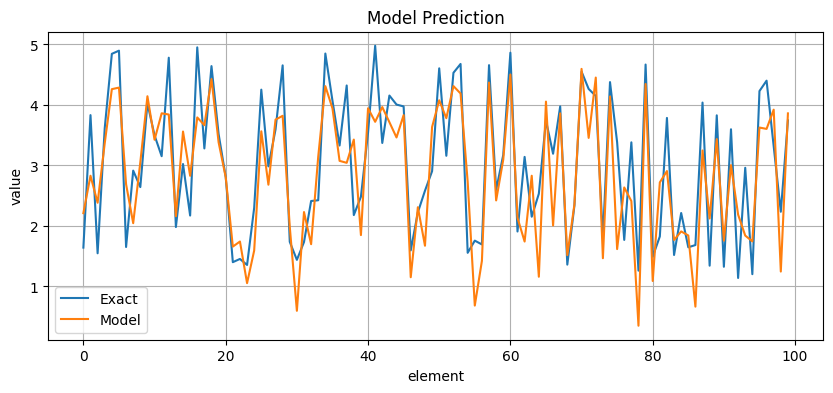

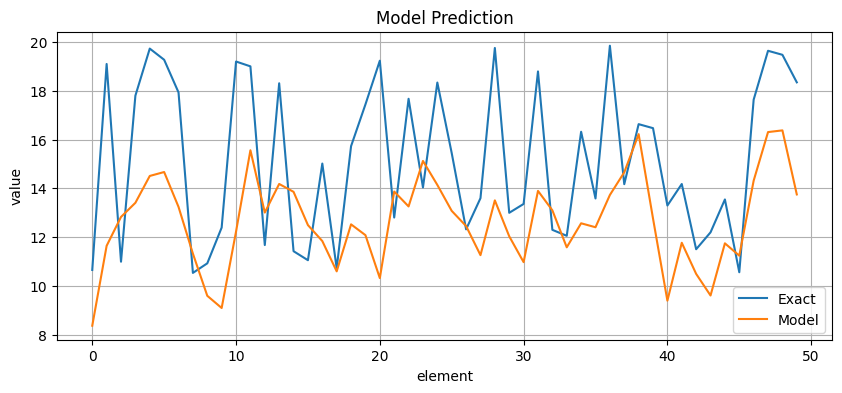

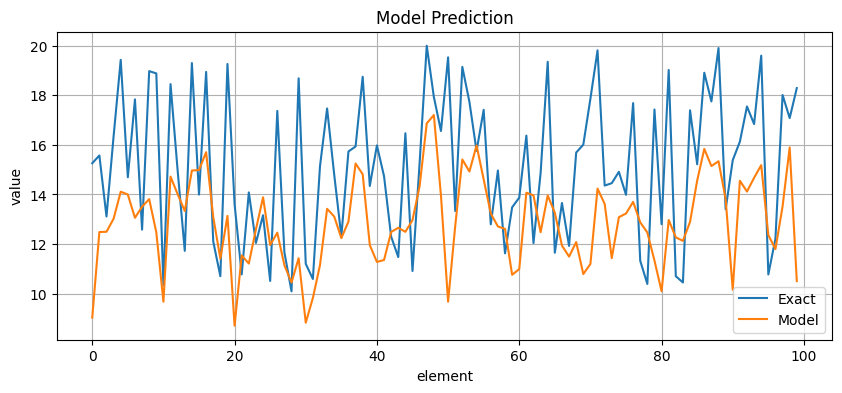

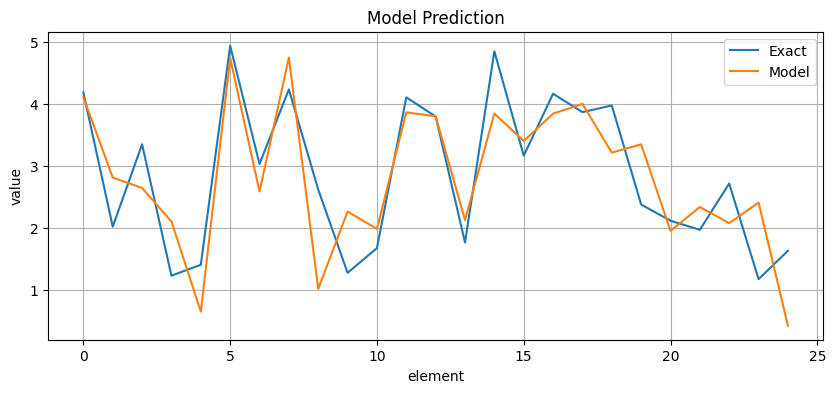

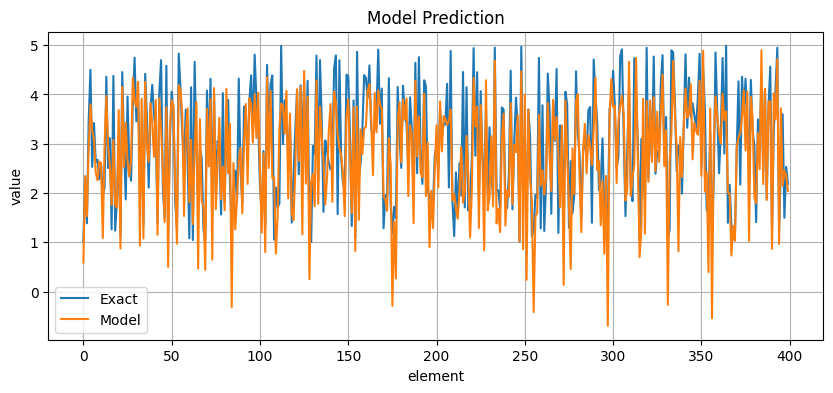

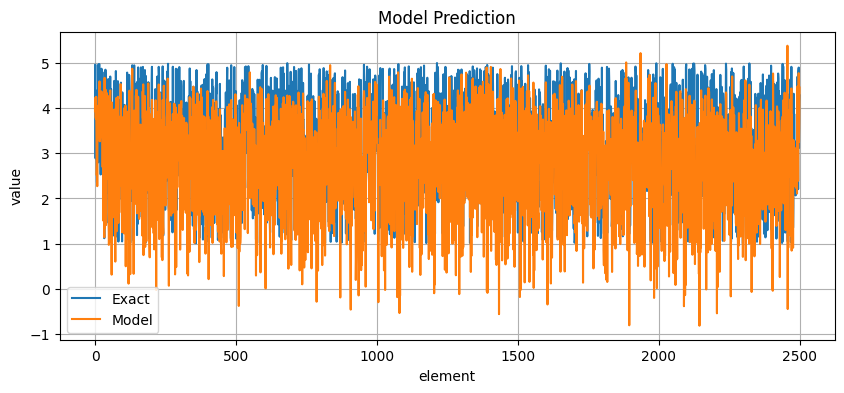

In [63]:
test_sample(model)
test_sample(model, ni=5, nj=10, min_val=10, max_val=20)
test_sample(model, ni=10, nj=10, min_val=10, max_val=20)
test_sample(model, ni=5, nj=5)
test_sample(model, ni=20, nj=20)
test_sample(model, ni=50, nj=50)

### Results

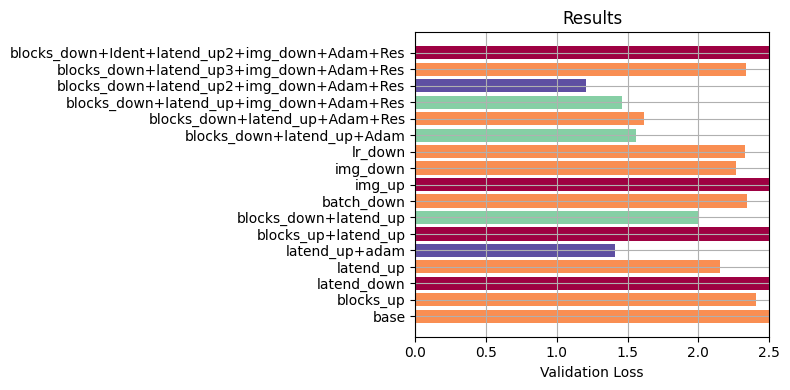

In [89]:
df = pd.read_csv('./solve_lin_eq_results.csv', header=0)
df.fillna(0, inplace=True)

cmap = mpl.cm.Spectral
norm = mpl.colors.Normalize(vmin=min(df['stars']), vmax=max(df['stars']))

plt.figure(figsize=(8, 4))
plt.barh(df['case'], df['val_loss'], color=cmap(norm(df['stars'])))
plt.xlabel('Validation Loss')
plt.xlim([0,2.5])
plt.title('Results')
plt.grid()
plt.tight_layout()
plt.show()